Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# Import libs
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x
import tensorflow as tf

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import math
from math import nan
import random
import json
from future.utils import iteritems
import pickle
from requests import get

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam

import keras as k
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

!pip install tensorflow-addons
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow_addons.text import crf_log_likelihood, crf_decode

!pip install transformers

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.3 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=1c97c36a7cace3e5652b695fcfb41de4fe20cbe62def05d968c15213b5e48060
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.2 MB/s 


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1hIe1NaUcYENwTFrG_z1WUEiEkEzhtzbx'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1fbR_cCVnnvMiJuaS7tvGE8nHHepciFuG'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1cz6lxw3dd-zeoKtLewT7pjSkIIh4BjOe'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1W3P_xzWN4P3YTFvHqw0wY-PUClLXne1K'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="utf-8")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="utf-8")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="utf-8")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  226
Number of dev sentences:  40
Number of test sentences:  48
Number of words in the training dataset:  5862
Number of words in the dev dataset:  1874
Number of words in the test dataset:  2030
Tags in the training dataset: ['B-AGMT_DATE', 'I-AGMT_DATE', 'B-PARTY', 'O', 'B-DOC_NAME', 'I-PARTY', 'I-DOC_NAME']
Number of Labels in the training dataset:  7
Tags in the dev dataset: ['B-AGMT_DATE', 'I-AGMT_DATE', 'B-PARTY', 'O', 'B-DOC_NAME', 'I-PARTY', 'I-DOC_NAME']
Number of Labels in the dev dataset:  7
Tags in the test dataset: ['B-AGMT_DATE', 'I-AGMT_DATE', 'B-PARTY', 'O', 'B-DOC_NAME', 'I-PARTY', 'I-DOC_NAME']
Number of Labels in the test dataset:  7
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 1,Exhibit,O
1,Sentence: 1,99.1,O
2,Sentence: 1,JOINT,B-DOC_NAME
3,Sentence: 1,FILING,I-DOC_NAME
4,Sentence: 1,AGREEMENT,I-DOC_NAME
5,Sentence: 1,The,O
6,Sentence: 1,undersigned,O
7,Sentence: 1,hereby,O
8,Sentence: 1,agree,O
9,Sentence: 1,that,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Exhibit', 'O'),
 ('10.8', 'O'),
 ('Services', 'B-DOC_NAME'),
 ('Agreement', 'I-DOC_NAME'),
 ('Oaktree', 'B-PARTY'),
 ('Capital', 'I-PARTY'),
 ('Management', 'I-PARTY'),
 (',', 'I-PARTY'),
 ('L.P.', 'I-PARTY'),
 ('and', 'O'),
 ('Oaktree', 'B-PARTY'),
 ('Capital', 'I-PARTY'),
 ('Management', 'I-PARTY'),
 ('(', 'I-PARTY'),
 ('International', 'I-PARTY'),
 (')', 'I-PARTY'),
 ('Limited', 'I-PARTY'),
 ('September', 'O'),
 ('2018', 'O'),
 ('1', 'O'),
 ('THIS', 'O'),
 ('SERVICES', 'B-DOC_NAME'),
 ('AGREEMENT', 'I-DOC_NAME'),
 ('(', 'O'),
 ('this', 'O'),
 ('“', 'O'),
 ('Agreement', 'O'),
 ('”', 'O'),
 (')', 'O'),
 ('is', 'O'),
 ('made', 'O'),
 ('on', 'O'),
 ('25', 'B-AGMT_DATE'),
 ('September', 'I-AGMT_DATE'),
 ('2018', 'I-AGMT_DATE'),
 ('BETWEEN', 'O'),
 (':', 'O'),
 ('(', 'O'),
 ('1', 'O'),
 (')', 'O'),
 ('Oaktree', 'B-PARTY'),
 ('Capital', 'I-PARTY'),
 ('Management', 'I-PARTY'),
 (',', 'I-PARTY'),
 ('L.P.', 'I-PARTY'),
 ('a', 'O'),
 ('Delaware', 'O'),
 ('limited', 'O'),
 ('partnership', 'O

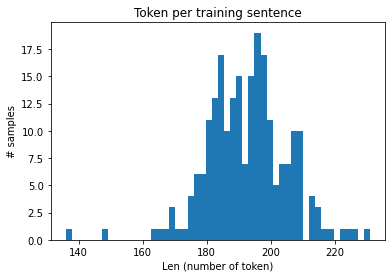

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

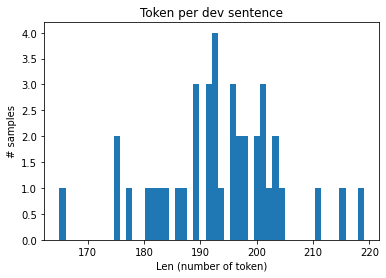

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

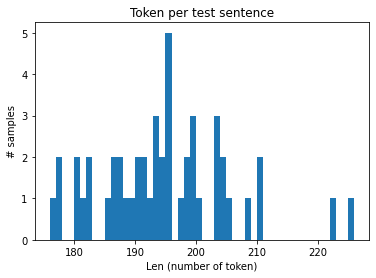

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i + 1 for i, w in enumerate(words)}
word2idx["PAD"] = 0 # Padding

idx2word = {i: w for w, i in iteritems(word2idx)}

tag2idx = {t: i for i, t in enumerate(tags)}

idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'business'
print(word2idx['business'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-PARTY'
print(tag2idx['B-PARTY'])
# Tag of index 2
print(idx2tag[2])

4146
WITNESSES
2
B-PARTY


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.77876)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 226
Points in y_train before removal: 226
Points in X_train before removal: 50
Points in y_train before removal: 50


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['business'])
print(tag2idx['B-PARTY'])
print(idx2tag[2])
print(idx2word[10])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[682, 2663, 5967, 6034, 18, 5082, 5332, 4340, 4340, 3496, 4064, 378, 1836, 3578, 3496, 4064, 378, 1836, 2570, 758, 4600, 5081, 7034, 4380, 424, 4058, 4108, 5188, 638, 680, 573, 6303, 5611, 3696, 679, 3747, 3761, 6303, 638, 680, 573, 6303, 5611, 3696, 2570, 4600, 1017, 5797, 7034, 4380, 424, 6480, 679, 2960, 2570, 1974, 4380, 3675, 7003, 424, 1616, 2570, 4600, 3675, 7034, 4380, 424, 1974, 423, 3532, 2570, 2725, 4902, 4380, 2751, 5873, 4340, 424, 5472, 1621, 6559, 4204, 6303, 4146, 4425, 5967, 6034, 18, 5082, 424, 5332, 4340, 424, 4340, 424, 2570, 2161, 4380, 3675, 2830, 424, 1616, 2570, 4600, 3675, 2275, 7034, 4380, 424, 1974, 423, 3532, 2570, 2725, 4902, 4380, 2751, 5873, 4340, 424, 5472, 1621, 6559, 4204, 6303, 4146, 4425, 5967, 6034, 18, 5082, 424, 5332, 2474, 2570, 1473, 4380, 5733, 851, 2570, 2296, 4380, 6852, 2570, 4600, 851, 2296, 7034, 4380, 424, 1974, 3532, 2751, 5873, 638, 3974, 5368, 1072, 5472, 423, 4946, 424, 2279, 3931, 1831, 6595, 4425, 5914, 6449, 424, 453, 4871, 424, 26

In [2]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam
import keras as k
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report
!pip install tensorflow-addons
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow_addons.text import crf_log_likelihood, crf_decode
!pip install transformers

BACKUP_FOLDER_ID = '1W3P_xzWN4P3YTFvHqw0wY-PUClLXne1K'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].replace("_CWR","")

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['business'])
print(tag2idx['B-PARTY'])
print(idx2tag[2])
print(idx2word[10])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.6 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=52bb92f93c0f18a4a9e1f33f7b549cba8a5c1293cc1c2651c36f05f6cb8617f5
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 3.5 MB/s 
     |████████████████████████████████| 163 kB 73.5 MB/s 
     |████████████████████████████████| 7.6 MB 52.8 MB/s 
[682, 2663, 5967, 6034, 18, 5082, 5332, 4340, 4340, 3496, 40

In [3]:
from transformers import pipeline
from future.utils import iteritems

# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    unmasker = pipeline('fill-mask', model='bert-base-multilingual-cased')
    
    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
      sequence_str = [idx2word[word] for word in sequence]
      replaceable_indices = [i for i,label in enumerate(base_labels[k]) if label == tag2idx["O"]]
      replace_percent = round(random.uniform(0.1, 1), 1)
      replace_qty = max(math.floor(replace_percent*len(replaceable_indices)), 1)
      replace_indices = random.sample(replaceable_indices, k=replace_qty)
      replace_indices.sort()

      masked_text_list = ["[MASK]" if i in replace_indices else word for i,word in enumerate(sequence_str)]
      new_mask_sent = ' '.join(masked_text_list)
      augmented_text_list = unmasker(new_mask_sent)

      augmented_sentence = sequence_str.copy()
      if len(replace_indices) == 1:
        augmented_text_list = [augmented_text_list]

      for i,index in enumerate(replace_indices):
        available_words = [word["token_str"] for word in augmented_text_list[i] if word["token_str"] != sequence_str[index]]
        new_word = random.choice(available_words)
        augmented_sentence[index] = new_word

      # print("Original text->",sequence_str)
      # print("Augmented text->",augmented_sentence)

      new_sequences.append(augmented_sentence)
      new_labels.append(base_labels[k])

    all_words = list(set([word for seq in new_sequences for word in seq]))
    updated_word2idx = word2idx.copy()
    updated_idx2word = idx2word.copy()
    for word in all_words:
      try:
        updated_word2idx[word]
      except:
        updated_word2idx[word] = len(updated_word2idx)
    updated_idx2word = {i: w for w, i in iteritems(updated_word2idx)}

    updated_n_words = len(updated_idx2word.items())

    new_sequences = [[updated_word2idx[word] for word in seq] for seq in new_sequences]

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx

In [4]:
# Graph plot function 
plt.style.use('ggplot')

def plot_history(history):
    # accuracy = history.history['crf_viterbi_accuracy']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [5]:
# This function converts predicted values to labels from idx2tag
# This is to improve the interpretability of the results
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out

In [6]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -oq glove.6B.zip

--2022-10-16 05:38:21--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-10-16 05:38:22--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-10-16 05:38:22--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [7]:
path_to_glove_file = "./glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [8]:
embedding_dim = 100

def generate_embedding_matrix(n_words, word2idx):
  num_tokens = n_words + 1
  hits = 0
  misses = 0

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word2idx.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # Words not found in embedding index will be all-zeros.
          # This includes the representation for "padding" and "OOV"
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))
  return embedding_matrix

In [9]:
class CRF(L.Layer):
    def __init__(self,
                 output_dim,
                 sparse_target=True,
                 **kwargs):
        """    
        Args:
            output_dim (int): the number of labels to tag each temporal input.
            sparse_target (bool): whether the the ground-truth label represented in one-hot.
        Input shape:
            (batch_size, sentence length, output_dim)
        Output shape:
            (batch_size, sentence length, output_dim)
        """
        super(CRF, self).__init__(**kwargs)
        self.output_dim = int(output_dim) 
        self.sparse_target = sparse_target
        self.input_spec = L.InputSpec(min_ndim=3)
        self.supports_masking = False
        self.sequence_lengths = None
        self.transitions = None

    def build(self, input_shape):
        assert len(input_shape) == 3
        f_shape = tf.TensorShape(input_shape)
        input_spec = L.InputSpec(min_ndim=3, axes={-1: f_shape[-1]})

        if f_shape[-1] is None:
            raise ValueError('The last dimension of the inputs to `CRF` '
                             'should be defined. Found `None`.')
        if f_shape[-1] != self.output_dim:
            raise ValueError('The last dimension of the input shape must be equal to output'
                             ' shape. Use a linear layer if needed.')
        self.input_spec = input_spec
        self.transitions = self.add_weight(name='transitions',
                                           shape=[self.output_dim, self.output_dim],
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.built = True

    def compute_mask(self, inputs, mask=None):
        # Just pass the received mask from previous layer, to the next layer or
        # manipulate it if this layer changes the shape of the input
        return mask

    def call(self, inputs, sequence_lengths=None, training=None, **kwargs):
        sequences = tf.convert_to_tensor(inputs, dtype=self.dtype)
        if sequence_lengths is not None:
            assert len(sequence_lengths.shape) == 2
            assert tf.convert_to_tensor(sequence_lengths).dtype == 'int32'
            seq_len_shape = tf.convert_to_tensor(sequence_lengths).get_shape().as_list()
            assert seq_len_shape[1] == 1
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype=tf.int32) * (
                tf.shape(inputs)[1]
            )

        viterbi_sequence, _ = crf_decode(sequences,
                                         self.transitions,
                                         self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        def crf_loss(y_true, y_pred):
            y_pred = tf.convert_to_tensor(y_pred, dtype=self.dtype)
            log_likelihood, self.transitions = crf_log_likelihood(
                y_pred,
                tf.cast(K.argmax(y_true), dtype=tf.int32) if self.sparse_target else y_true,
                self.sequence_lengths,
                transition_params=self.transitions,
            )
            return tf.reduce_mean(-log_likelihood)
        return crf_loss

    @property
    def accuracy(self):
        def viterbi_accuracy(y_true, y_pred):
            # -1e10 to avoid zero at sum(mask)
            mask = K.cast(
                K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * (shape[1])
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            if self.sparse_target:
                y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

    def compute_output_shape(self, input_shape):
        tf.TensorShape(input_shape).assert_has_rank(3)
        return input_shape[:2] + (self.output_dim,)

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'sparse_target': self.sparse_target,
            'supports_masking': self.supports_masking,
            'transitions': K.eval(self.transitions)
        }
        base_config = super(CRF, self).get_config()
        return dict(base_config, **config)

In [10]:
# Model creation function
def create_model(maxlen, n_words, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=n_words+1, output_dim=embedding_dim, 
                    input_length=maxlen, weights=[embedding_matrix], mask_zero=True))
    model.add(Bidirectional(LSTM(units=embedding_dim, return_sequences=True, 
                              dropout=0.1)))
    model.add(TimeDistributed(Dense(n_tags)))
    crf = CRF(n_tags, sparse_target=True)
    model.add(crf)
    adam = Adam(learning_rate=0.005)
    model.compile(optimizer=adam, loss=crf.loss, metrics=[crf.accuracy, 'accuracy'])
    model.summary()
    return model

In [11]:
# Model training function
def train(model, X_train_df, y_train_df, X_dev_df, y_dev_df):
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
  callbacks_list = [early_stopping]

  batch_size = round(0.05*len(X_train_df))
  if batch_size > 16:
    batch_size = 16
  if batch_size < 10:
    batch_size = 10

  history = model.fit(X_train_df, np.array(y_train_df),
                      batch_size=batch_size,
                      epochs=500,
                      validation_data=(X_dev_df,  np.array(y_dev_df)),
                      validation_batch_size=512,
                      verbose=1,
                      callbacks=callbacks_list)
  plot_history(history)

In [12]:
# Model testing function
def test(model, X_test_df, y_test_df):
  test_pred = model.predict(X_test_df, verbose=1)   

  pred_labels = pred2label(test_pred)
  test_labels = pred2label(y_test_df)
  
  print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
  report = classification_report(y_pred=pred_labels, y_true=test_labels, output_dict=True)
  df = pd.DataFrame(report).transpose()
  print("Classification Report:")
  print(df.to_csv())

In [13]:
def create_train_and_validate_model(augmented_percentage):
  augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx = generate_sentences(X_train, y_train, augmented_percentage)

  # Preparing data for training. 
  # X = observations vector. For text sequence labeling, observations are the index of the words in the sentences
  # y = labels vector. For text sequence labeling, labels are the index of tags in the sentences
  # The BI-LSTM layer expects all texts/sentences to be of the same length. 
  # So, we need to pad shorter sentences
  # We select the padding size to be the length of the longest sentence.

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_dev = max([len(s) for s in y_dev])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_y_test = max([len(s) for s in y_test])

  maxlen = max([maxlen_X_train, maxlen_y_train, maxlen_X_dev, maxlen_y_dev, maxlen_X_test, maxlen_y_test])

  augmented_X_train = pad_sequences(maxlen=maxlen, sequences=augmented_X_train, padding="post",value=updated_word2idx["PAD"])
  new_X_dev = pad_sequences(maxlen=maxlen, sequences=X_dev, padding="post",value=updated_word2idx["PAD"])
  new_X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post",value=updated_word2idx["PAD"])

  augmented_y_train = pad_sequences(maxlen=maxlen, sequences=augmented_y_train, padding="post", value=tag2idx["O"])
  new_y_dev = pad_sequences(maxlen=maxlen, sequences=y_dev, padding="post", value=tag2idx["O"])
  new_y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idx["O"])

  # Converts vector y (integers) to binary matrix.
  # Each y is a one-hot vector where only the position of the tag gests "1"
  augmented_y_train = [to_categorical(i, num_classes=n_tags) for i in augmented_y_train]
  new_y_dev = [to_categorical(i, num_classes=n_tags) for i in new_y_dev]
  new_y_test = [to_categorical(i, num_classes=n_tags) for i in new_y_test]

  embedding_matrix = generate_embedding_matrix(updated_n_words, updated_word2idx)

  model = None
  model = create_model(maxlen, updated_n_words, embedding_matrix)

  train(model, augmented_X_train, augmented_y_train, new_X_dev, new_y_dev)

  test(model, new_X_test, new_y_test)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Converted 2804 words (4483 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 226, 100)          728800    
                                                                 
 bidirectional (Bidirectiona  (None, 226, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 226, 7)           1407      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 226, 7)            49        
                                                                 
Total params: 891,056
Trainable params: 891,056
Non-trainable params: 0

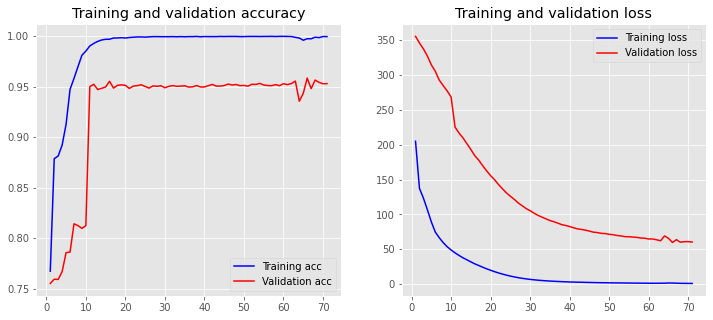

2/2 [==============================] - 3s 61ms/step
F1-score: 52.0%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.5932203389830508,0.7,0.6422018348623852,50.0
DOC_NAME,0.5050505050505051,0.6097560975609756,0.5524861878453039,82.0
PARTY,0.41216216216216217,0.49193548387096775,0.4485294117647059,124.0
micro avg,0.477124183006536,0.5703125,0.5195729537366548,256.0
macro avg,0.503477668731906,0.6005638604773144,0.5477391448241317,256.0
weighted avg,0.4772783846539143,0.5703125,0.5196547117392879,256.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Converted 2808 words (4500 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 226, 100)          730900    
                                                                 
 bidirectional_1 (Bidirectio  (None, 226, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 226, 7)           1407      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 226, 7)            49        
                                                                 
Total params: 893,156
Trainable params: 893,156
Non-trainable params:

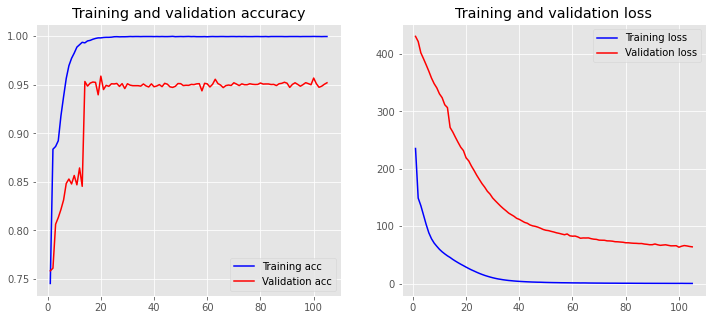

2/2 [==============================] - 3s 57ms/step
F1-score: 55.3%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.7254901960784313,0.74,0.7326732673267328,50.0
DOC_NAME,0.5408163265306123,0.6463414634146342,0.5888888888888889,82.0
PARTY,0.45528455284552843,0.45161290322580644,0.4534412955465587,124.0
micro avg,0.5367647058823529,0.5703125,0.5530303030303031,256.0
macro avg,0.5738636918181907,0.6126514555468136,0.5916678172540601,256.0
weighted avg,0.5354559887979582,0.5703125,0.5513643472773391,256.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Converted 2801 words (4489 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 226, 100)          729100    
                                                                 
 bidirectional_2 (Bidirectio  (None, 226, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 226, 7)           1407      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 226, 7)            49        
                                                                 
Total params: 891,356
Trainable params: 891,356
Non-trainable params:

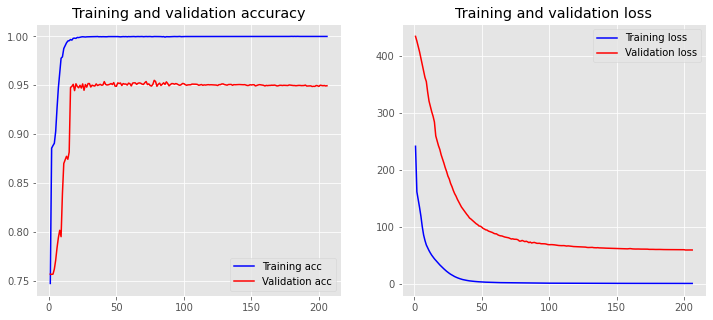

2/2 [==============================] - 3s 57ms/step
F1-score: 48.9%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.5555555555555556,0.6,0.576923076923077,50.0
DOC_NAME,0.5617977528089888,0.6097560975609756,0.5847953216374269,82.0
PARTY,0.36879432624113473,0.41935483870967744,0.39245283018867927,124.0
micro avg,0.4647887323943662,0.515625,0.4888888888888889,256.0
macro avg,0.49538254486855965,0.5430369787568844,0.5180570762497276,256.0
weighted avg,0.4670925389141233,0.515625,0.4900918795461683,256.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Converted 2806 words (4499 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 226, 100)          730600    
                                                                 
 bidirectional_3 (Bidirectio  (None, 226, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 226, 7)           1407      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 226, 7)            49        
                                                                 
Total params: 892,856
Trainable params: 892,856
Non-trainable params:

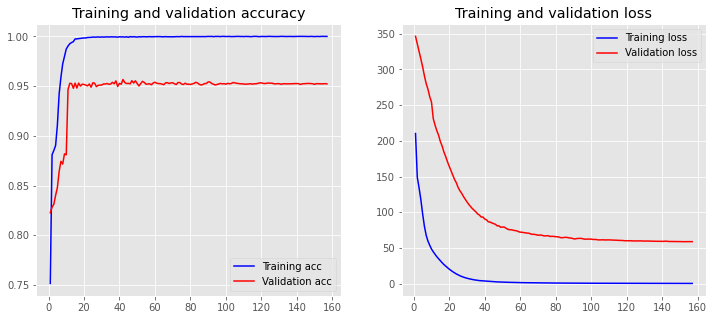

2/2 [==============================] - 3s 58ms/step
F1-score: 50.8%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.5636363636363636,0.62,0.5904761904761904,50.0
DOC_NAME,0.5581395348837209,0.5853658536585366,0.5714285714285714,82.0
PARTY,0.417910447761194,0.45161290322580644,0.43410852713178294,124.0
micro avg,0.4909090909090909,0.52734375,0.5084745762711864,256.0
macro avg,0.5132287820937594,0.552326252294781,0.5320044296788482,256.0
weighted avg,0.4912896701744975,0.52734375,0.5086344130675526,256.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Converted 2804 words (4506 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 226, 100)          731100    
                                                                 
 bidirectional_4 (Bidirectio  (None, 226, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 226, 7)           1407      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 226, 7)            49        
                                                                 
Total params: 893,356
Trainable params: 893,356
Non-trainable params:

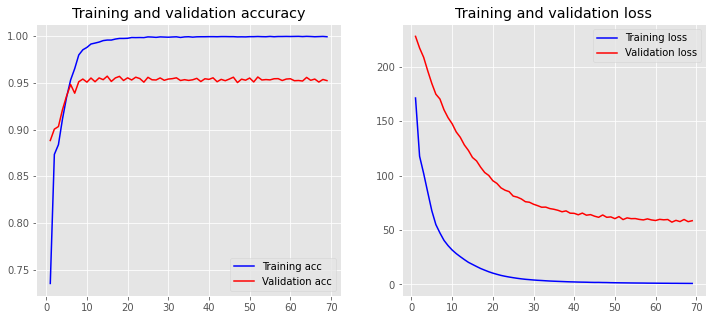

2/2 [==============================] - 3s 59ms/step
F1-score: 51.5%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.5230769230769231,0.68,0.591304347826087,50.0
DOC_NAME,0.5824175824175825,0.6463414634146342,0.6127167630057804,82.0
PARTY,0.39705882352941174,0.43548387096774194,0.4153846153846154,124.0
micro avg,0.4828767123287671,0.55078125,0.5145985401459854,256.0
macro avg,0.5008511096746391,0.587275111460792,0.5398019087388276,256.0
weighted avg,0.48104446105365223,0.55078125,0.5129518916619947,256.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Converted 2814 words (4514 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 226, 100)          732900    
                                                                 
 bidirectional_5 (Bidirectio  (None, 226, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 226, 7)           1407      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 226, 7)            49        
                                                                 
Total params: 895,156
Trainable params: 895,156
Non-trainable params:

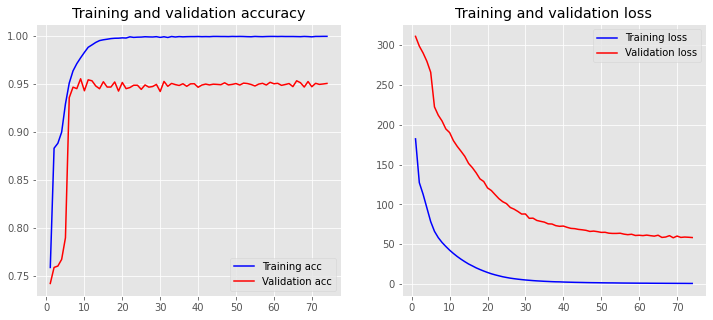

2/2 [==============================] - 3s 59ms/step
F1-score: 53.3%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.5555555555555556,0.7,0.6194690265486726,50.0
DOC_NAME,0.5520833333333334,0.6463414634146342,0.5955056179775281,82.0
PARTY,0.4576271186440678,0.43548387096774194,0.4462809917355372,124.0
micro avg,0.5126353790613718,0.5546875,0.5328330206378987,256.0
macro avg,0.5217553358443189,0.5939417781274586,0.5537518787539126,256.0
weighted avg,0.5070092727459982,0.5546875,0.5279052928781154,256.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Converted 2822 words (4502 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 226, 100)          732500    
                                                                 
 bidirectional_6 (Bidirectio  (None, 226, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 226, 7)           1407      
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 226, 7)            49        
                                                                 
Total params: 894,756
Trainable params: 894,756
Non-trainable params:

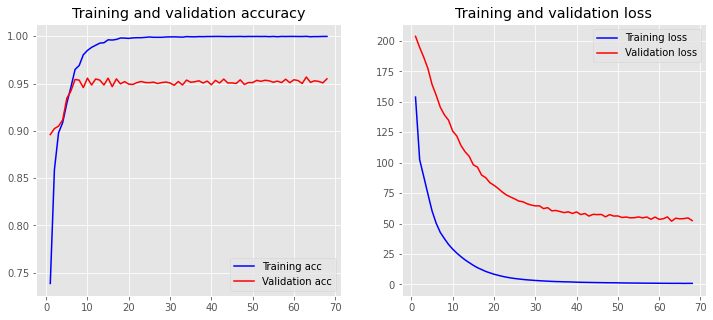

2/2 [==============================] - 3s 61ms/step
F1-score: 58.9%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.6610169491525424,0.78,0.7155963302752293,50.0
DOC_NAME,0.6206896551724138,0.6585365853658537,0.6390532544378699,82.0
PARTY,0.5327102803738317,0.4596774193548387,0.49350649350649345,124.0
micro avg,0.5928853754940712,0.5859375,0.5893909626719056,256.0
macro avg,0.6048056282329293,0.6327380015735641,0.6160520260731975,256.0
weighted avg,0.5859510701098445,0.5859375,0.5835038616112187,256.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Converted 2808 words (4491 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 226, 100)          730000    
                                                                 
 bidirectional_7 (Bidirectio  (None, 226, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 226, 7)           1407      
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 226, 7)            49        
                                                                 
Total params: 892,256
Trainable params: 892,256
Non-trainable params:

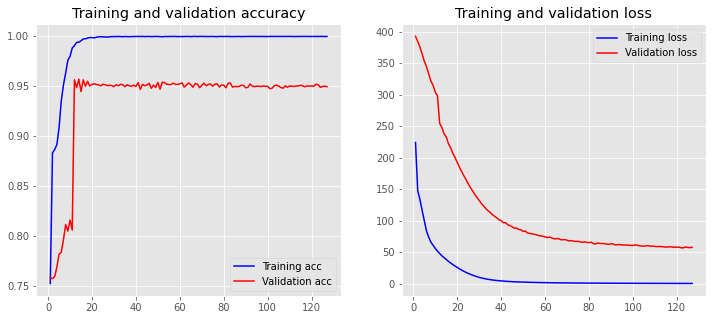

2/2 [==============================] - 3s 62ms/step
F1-score: 54.8%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.6481481481481481,0.7,0.673076923076923,50.0
DOC_NAME,0.5212765957446809,0.5975609756097561,0.5568181818181819,82.0
PARTY,0.54,0.43548387096774194,0.4821428571428571,124.0
micro avg,0.5564516129032258,0.5390625,0.5476190476190476,256.0
macro avg,0.5698082479642763,0.5776816155258326,0.5706793206793207,256.0
weighted avg,0.5551253447596534,0.5390625,0.5433541068306693,256.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Converted 2811 words (4498 misses)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 226, 100)          731000    
                                                                 
 bidirectional_8 (Bidirectio  (None, 226, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 226, 7)           1407      
 tributed)                                                       
                                                                 
 crf_8 (CRF)                 (None, 226, 7)            49        
                                                                 
Total params: 893,256
Trainable params: 893,256
Non-trainable params:

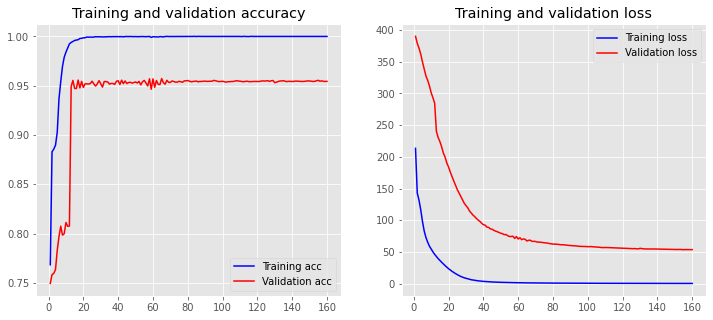

2/2 [==============================] - 3s 59ms/step
F1-score: 53.2%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.6428571428571429,0.72,0.6792452830188679,50.0
DOC_NAME,0.5463917525773195,0.6463414634146342,0.5921787709497207,82.0
PARTY,0.4297520661157025,0.41935483870967744,0.4244897959183674,124.0
micro avg,0.5145985401459854,0.55078125,0.5320754716981132,256.0
macro avg,0.5396669871833883,0.5952321007081038,0.5653046166289853,256.0
weighted avg,0.5087353009865018,0.55078125,0.5279596018074142,256.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Converted 2806 words (4492 misses)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 226, 100)          729900    
                                                                 
 bidirectional_9 (Bidirectio  (None, 226, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 226, 7)           1407      
 tributed)                                                       
                                                                 
 crf_9 (CRF)                 (None, 226, 7)            49        
                                                                 
Total params: 892,156
Trainable params: 892,156
Non-trainable params:

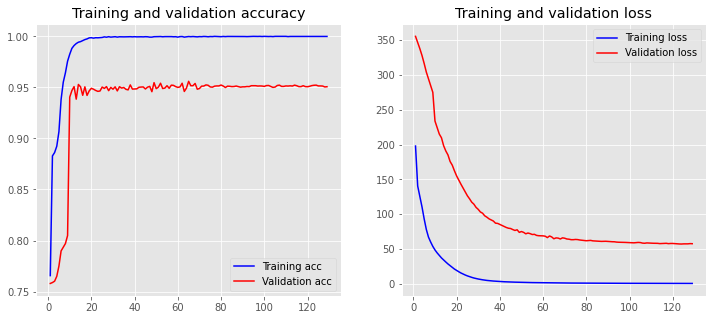

2/2 [==============================] - 3s 58ms/step
F1-score: 54.5%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.6538461538461539,0.68,0.6666666666666666,50.0
DOC_NAME,0.5434782608695652,0.6097560975609756,0.5747126436781609,82.0
PARTY,0.5094339622641509,0.43548387096774194,0.46956521739130436,124.0
micro avg,0.552,0.5390625,0.5454545454545454,256.0
macro avg,0.5689194589932901,0.5750799895095725,0.5703148425787106,256.0
weighted avg,0.5485442828295577,0.5390625,0.5417416291854074,256.0



In [14]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Converted 2817 words (4550 misses)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 226, 100)          736800    
                                                                 
 bidirectional_10 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_10 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 899,056
Trainable params: 899,056
Non-trainable params

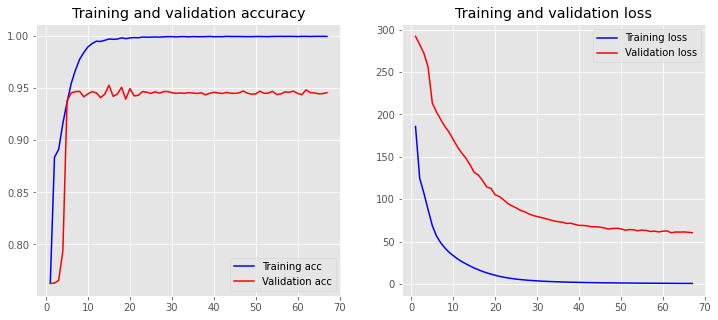

2/2 [==============================] - 3s 59ms/step
F1-score: 52.6%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.5833333333333334,0.7,0.6363636363636365,50.0
DOC_NAME,0.5555555555555556,0.6707317073170732,0.6077348066298344,82.0
PARTY,0.45918367346938777,0.3629032258064516,0.40540540540540543,124.0
micro avg,0.5252918287937743,0.52734375,0.5263157894736843,256.0
macro avg,0.5326908541194255,0.5778783110411748,0.5498346161329588,256.0
weighted avg,0.5143007723922903,0.52734375,0.5153230712191348,256.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Converted 2821 words (4549 misses)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 226, 100)          737100    
                                                                 
 bidirectional_11 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_11 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_11 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 899,356
Trainable params: 899,356
Non-trainable params

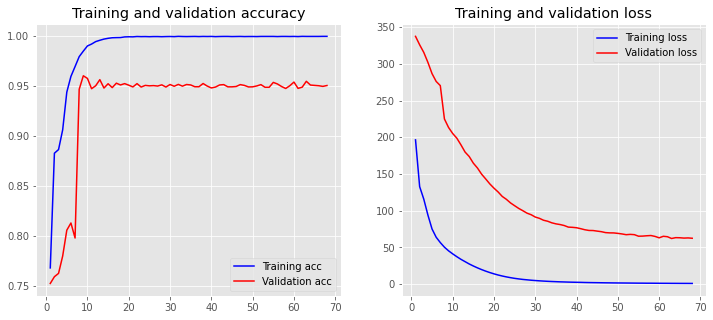

2/2 [==============================] - 3s 57ms/step
F1-score: 53.8%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.6666666666666666,0.68,0.6732673267326733,50.0
DOC_NAME,0.6162790697674418,0.6463414634146342,0.6309523809523809,82.0
PARTY,0.41732283464566927,0.4274193548387097,0.4223107569721115,124.0
micro avg,0.5303030303030303,0.546875,0.5384615384615384,256.0
macro avg,0.566756190359926,0.5845869394177813,0.575510154885722,256.0
weighted avg,0.5297509708997131,0.546875,0.5381562321846513,256.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Converted 2819 words (4527 misses)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 226, 100)          734700    
                                                                 
 bidirectional_12 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_12 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_12 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 896,956
Trainable params: 896,956
Non-trainable params

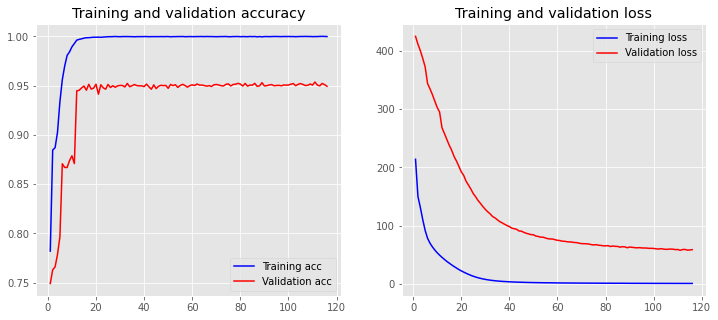

2/2 [==============================] - 3s 56ms/step
F1-score: 51.4%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.639344262295082,0.78,0.7027027027027027,50.0
DOC_NAME,0.5,0.5609756097560976,0.5287356321839081,82.0
PARTY,0.4090909090909091,0.43548387096774194,0.421875,124.0
micro avg,0.48771929824561405,0.54296875,0.5138632162661738,256.0
macro avg,0.5161450571286638,0.5921531602412798,0.5511044449622036,256.0
weighted avg,0.48318158532041733,0.54296875,0.5109529569305297,256.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Converted 2812 words (4533 misses)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 226, 100)          734600    
                                                                 
 bidirectional_13 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_13 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_13 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 896,856
Trainable params: 896,856
Non-trainable params

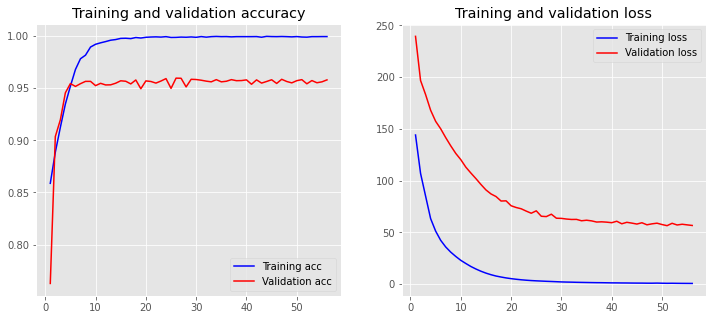

2/2 [==============================] - 3s 57ms/step
F1-score: 52.7%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.6491228070175439,0.74,0.6915887850467289,50.0
DOC_NAME,0.46788990825688076,0.6219512195121951,0.5340314136125655,82.0
PARTY,0.4393939393939394,0.46774193548387094,0.453125,124.0
micro avg,0.4899328859060403,0.5703125,0.5270758122743683,256.0
macro avg,0.518802218222788,0.609897718332022,0.5595817328864315,256.0
weighted avg,0.48948422387808554,0.5703125,0.5256152936272142,256.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Converted 2813 words (4534 misses)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 226, 100)          734800    
                                                                 
 bidirectional_14 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_14 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_14 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 897,056
Trainable params: 897,056
Non-trainable params

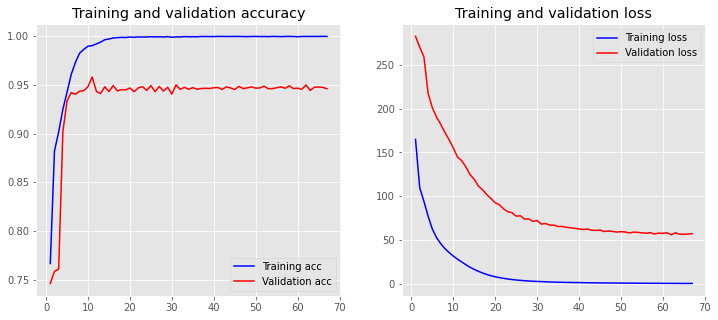

2/2 [==============================] - 3s 63ms/step
F1-score: 52.9%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.6666666666666666,0.72,0.6923076923076923,50.0
DOC_NAME,0.5268817204301075,0.5975609756097561,0.5599999999999999,82.0
PARTY,0.48,0.3870967741935484,0.42857142857142855,124.0
micro avg,0.5384615384615384,0.51953125,0.5288270377733599,256.0
macro avg,0.5578494623655913,0.5682192499344348,0.5602930402930403,256.0
weighted avg,0.5314751344086022,0.51953125,0.5221806318681318,256.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Converted 2809 words (4541 misses)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 226, 100)          735100    
                                                                 
 bidirectional_15 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_15 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_15 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 897,356
Trainable params: 897,356
Non-trainable params

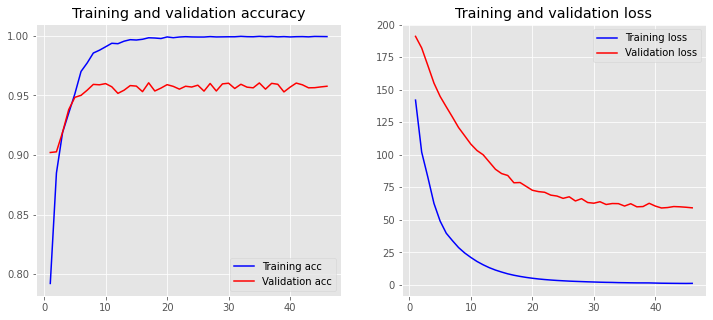

2/2 [==============================] - 3s 59ms/step
F1-score: 56.4%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.6851851851851852,0.74,0.7115384615384615,50.0
DOC_NAME,0.5510204081632653,0.6585365853658537,0.6,82.0
PARTY,0.49557522123893805,0.45161290322580644,0.47257383966244726,124.0
micro avg,0.5547169811320755,0.57421875,0.564299424184261,256.0
macro avg,0.5772602715291294,0.61671649619722,0.5947041004003029,256.0
weighted avg,0.550368203758888,0.57421875,0.5600628093557286,256.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Converted 2820 words (4538 misses)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 226, 100)          735900    
                                                                 
 bidirectional_16 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_16 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_16 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 898,156
Trainable params: 898,156
Non-trainable params

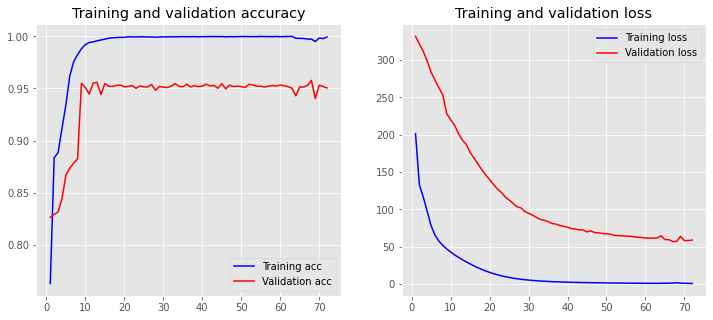

2/2 [==============================] - 3s 56ms/step
F1-score: 52.0%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.4444444444444444,0.56,0.4955752212389381,50.0
DOC_NAME,0.47619047619047616,0.6097560975609756,0.5347593582887701,82.0
PARTY,0.5,0.5403225806451613,0.5193798449612403,124.0
micro avg,0.48013245033112584,0.56640625,0.5197132616487454,256.0
macro avg,0.4735449735449735,0.5700262260687123,0.5165714748296495,256.0
weighted avg,0.48152281746031744,0.56640625,0.5196567547532025,256.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Converted 2824 words (4529 misses)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 226, 100)          735400    
                                                                 
 bidirectional_17 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_17 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_17 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 897,656
Trainable params: 897,656
Non-trainable params

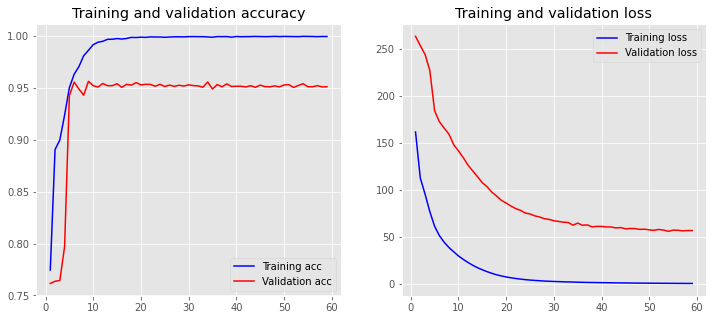

2/2 [==============================] - 3s 58ms/step
F1-score: 55.3%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.7222222222222222,0.78,0.7500000000000001,50.0
DOC_NAME,0.5625,0.6585365853658537,0.6067415730337078,82.0
PARTY,0.4537037037037037,0.3951612903225806,0.4224137931034483,124.0
micro avg,0.5503875968992248,0.5546875,0.5525291828793774,256.0
macro avg,0.5794753086419754,0.6112326252294781,0.5930517887123855,256.0
weighted avg,0.5409975405092593,0.5546875,0.5454379661468423,256.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Converted 2820 words (4536 misses)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 226, 100)          735700    
                                                                 
 bidirectional_18 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_18 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_18 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 897,956
Trainable params: 897,956
Non-trainable params

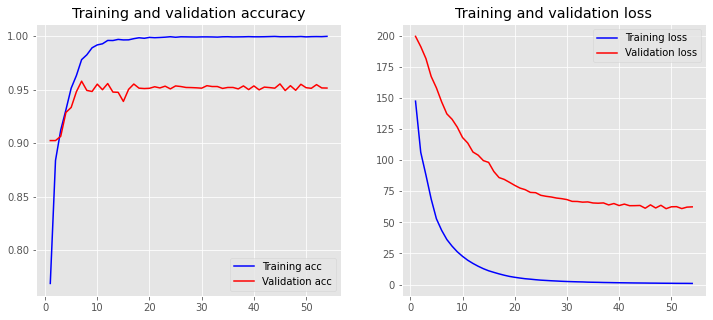

2/2 [==============================] - 3s 58ms/step
F1-score: 54.4%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.6551724137931034,0.76,0.7037037037037037,50.0
DOC_NAME,0.5652173913043478,0.6341463414634146,0.5977011494252873,82.0
PARTY,0.44166666666666665,0.4274193548387097,0.4344262295081967,124.0
micro avg,0.5296296296296297,0.55859375,0.5437262357414449,256.0
macro avg,0.5540188239213727,0.6071885654340414,0.5786103608790626,256.0
weighted avg,0.5229418493878061,0.55859375,0.5393184839729497,256.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Converted 2820 words (4549 misses)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 226, 100)          737000    
                                                                 
 bidirectional_19 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_19 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_19 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 899,256
Trainable params: 899,256
Non-trainable params

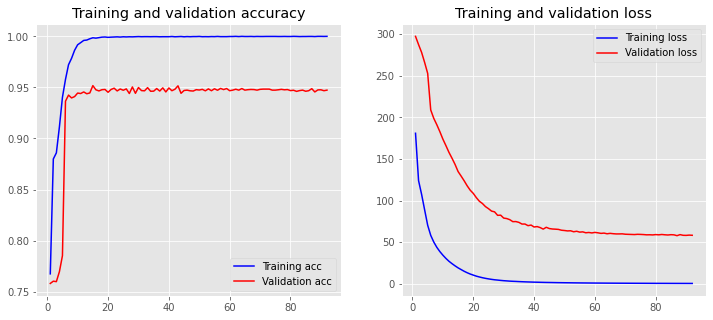

2/2 [==============================] - 3s 59ms/step
F1-score: 51.8%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.5925925925925926,0.64,0.6153846153846153,50.0
DOC_NAME,0.5376344086021505,0.6097560975609756,0.5714285714285714,82.0
PARTY,0.49473684210526314,0.3790322580645161,0.4292237442922374,124.0
micro avg,0.5330578512396694,0.50390625,0.5180722891566266,256.0
macro avg,0.5416546144333354,0.542929451875164,0.5386789770351413,256.0
weighted avg,0.5275899201408539,0.50390625,0.5111332731195745,256.0



In [15]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Converted 2846 words (4561 misses)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 226, 100)          740800    
                                                                 
 bidirectional_20 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_20 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_20 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 903,056
Trainable params: 903,056
Non-trainable params

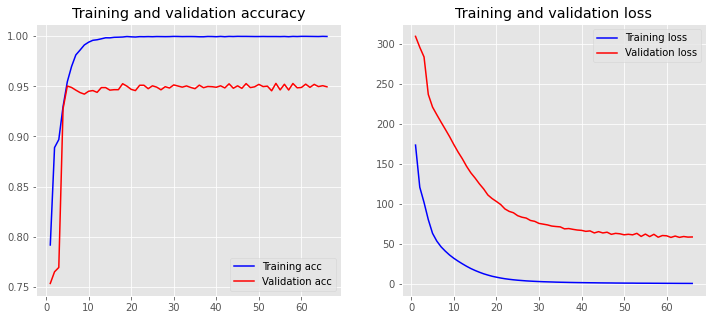

2/2 [==============================] - 23s 20s/step
F1-score: 49.4%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.6,0.66,0.6285714285714286,50.0
DOC_NAME,0.5263157894736842,0.6097560975609756,0.5649717514124293,82.0
PARTY,0.3828125,0.3951612903225806,0.3888888888888889,124.0
micro avg,0.4748201438848921,0.515625,0.49438202247191015,256.0
macro avg,0.5030427631578948,0.5549724626278522,0.5274773562909155,256.0
weighted avg,0.4711978310032895,0.515625,0.49210342682270647,256.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Converted 2820 words (4570 misses)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 226, 100)          739100    
                                                                 
 bidirectional_21 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_21 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_21 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 901,356
Trainable params: 901,356
Non-trainable params

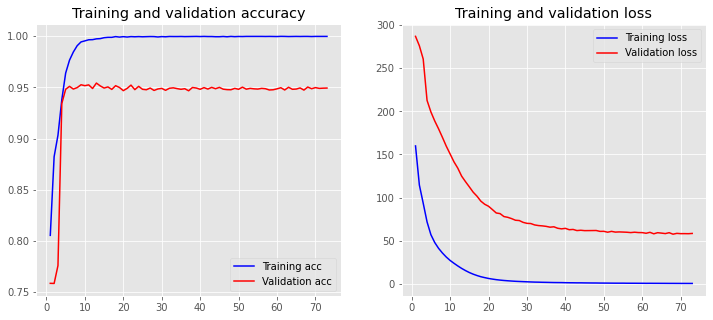

2/2 [==============================] - 3s 60ms/step
F1-score: 53.3%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.6724137931034483,0.78,0.7222222222222223,50.0
DOC_NAME,0.5531914893617021,0.6341463414634146,0.5909090909090909,82.0
PARTY,0.408,0.4112903225806452,0.40963855421686746,124.0
micro avg,0.5126353790613718,0.5546875,0.5328330206378987,256.0
macro avg,0.5445350941550501,0.6084788880146866,0.5742566224493936,256.0
weighted avg,0.5061499679016874,0.5546875,0.5287532706583912,256.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Converted 2840 words (4549 misses)
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 226, 100)          739000    
                                                                 
 bidirectional_22 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_22 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_22 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 901,256
Trainable params: 901,256
Non-trainable params

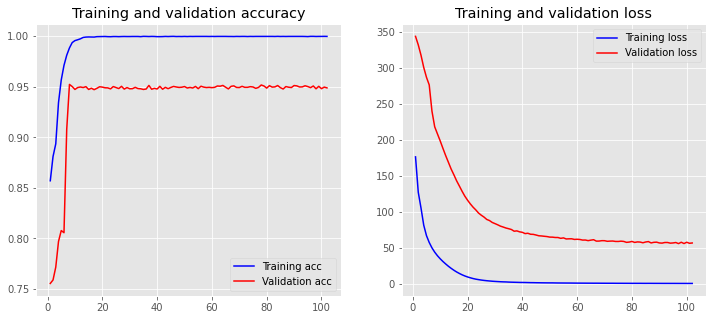

2/2 [==============================] - 3s 62ms/step
F1-score: 53.7%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.74,0.74,0.74,50.0
DOC_NAME,0.5757575757575758,0.6951219512195121,0.6298342541436464,82.0
PARTY,0.39655172413793105,0.3709677419354839,0.38333333333333336,124.0
micro avg,0.5283018867924528,0.546875,0.5374280230326296,256.0
macro avg,0.5707697666318357,0.602029897718332,0.5843891958256598,256.0
weighted avg,0.5210333398641589,0.546875,0.5319521178637201,256.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Converted 2849 words (4563 misses)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 226, 100)          741300    
                                                                 
 bidirectional_23 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_23 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_23 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 903,556
Trainable params: 903,556
Non-trainable params

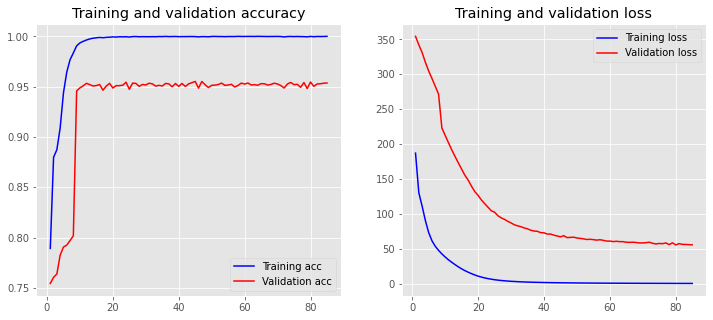

2/2 [==============================] - 3s 57ms/step
F1-score: 51.5%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.5636363636363636,0.62,0.5904761904761904,50.0
DOC_NAME,0.5842696629213483,0.6341463414634146,0.608187134502924,82.0
PARTY,0.4140625,0.4274193548387097,0.4206349206349206,124.0
micro avg,0.5,0.53125,0.5151515151515151,256.0
macro avg,0.5206561755192373,0.5605218987673748,0.539766081871345,256.0
weighted avg,0.49779562711472164,0.53125,0.5138823621553884,256.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Converted 2833 words (4559 misses)
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 226, 100)          739300    
                                                                 
 bidirectional_24 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_24 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_24 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 901,556
Trainable params: 901,556
Non-trainable params

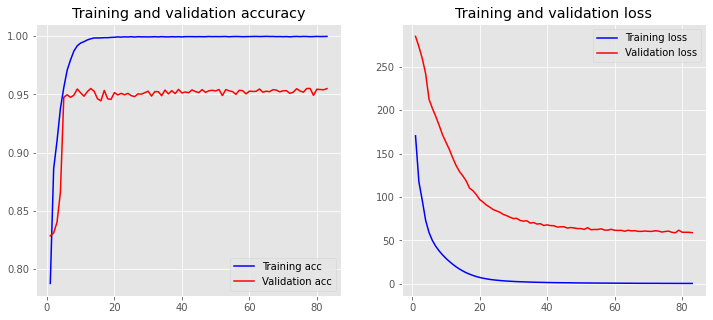

2/2 [==============================] - 3s 58ms/step
F1-score: 52.6%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.603448275862069,0.7,0.6481481481481481,50.0
DOC_NAME,0.6041666666666666,0.7073170731707317,0.6516853932584269,82.0
PARTY,0.391304347826087,0.3629032258064516,0.37656903765690375,124.0
micro avg,0.5130111524163569,0.5390625,0.5257142857142857,256.0
macro avg,0.5329730967849408,0.5900734329923943,0.5588008596878263,256.0
weighted avg,0.5009211702742379,0.5390625,0.5177350403283378,256.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Converted 2842 words (4580 misses)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 226, 100)          742300    
                                                                 
 bidirectional_25 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_25 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_25 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 904,556
Trainable params: 904,556
Non-trainable params

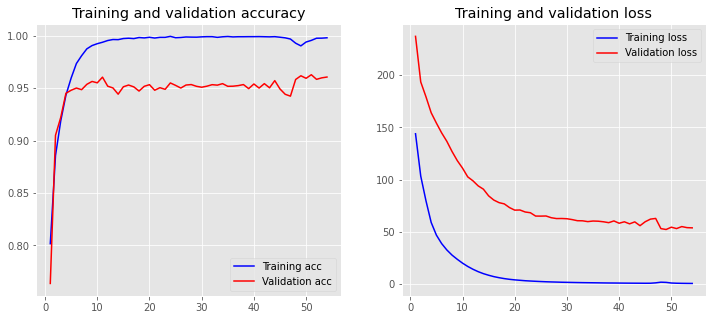

2/2 [==============================] - 3s 58ms/step
F1-score: 58.6%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.5625,0.72,0.631578947368421,50.0
DOC_NAME,0.5263157894736842,0.6097560975609756,0.5649717514124293,82.0
PARTY,0.5225806451612903,0.6532258064516129,0.5806451612903226,124.0
micro avg,0.5318471337579618,0.65234375,0.5859649122807018,256.0
macro avg,0.5371321448783247,0.6609939680041962,0.5923986200237242,256.0
weighted avg,0.5315738075657894,0.65234375,0.5855727772821885,256.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Converted 2840 words (4582 misses)
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 226, 100)          742300    
                                                                 
 bidirectional_26 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_26 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_26 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 904,556
Trainable params: 904,556
Non-trainable params

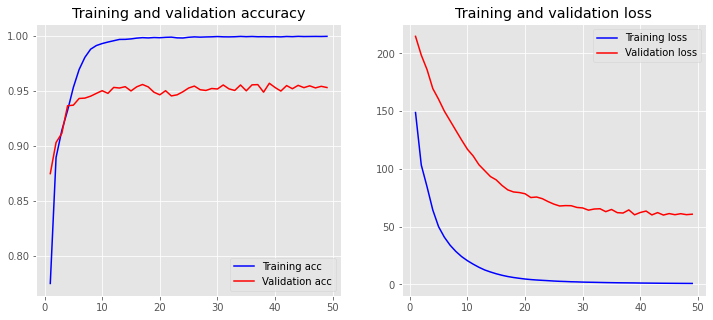

2/2 [==============================] - 3s 58ms/step
F1-score: 55.6%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.6140350877192983,0.7,0.6542056074766356,50.0
DOC_NAME,0.5531914893617021,0.6341463414634146,0.5909090909090909,82.0
PARTY,0.5135135135135135,0.4596774193548387,0.48510638297872344,124.0
micro avg,0.549618320610687,0.5625,0.555984555984556,256.0
macro avg,0.560246696864838,0.5979412536060844,0.5767403604548167,256.0
weighted avg,0.5458559851144538,0.5625,0.5520235051474178,256.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Converted 2840 words (4533 misses)
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 226, 100)          737400    
                                                                 
 bidirectional_27 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_27 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_27 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 899,656
Trainable params: 899,656
Non-trainable params

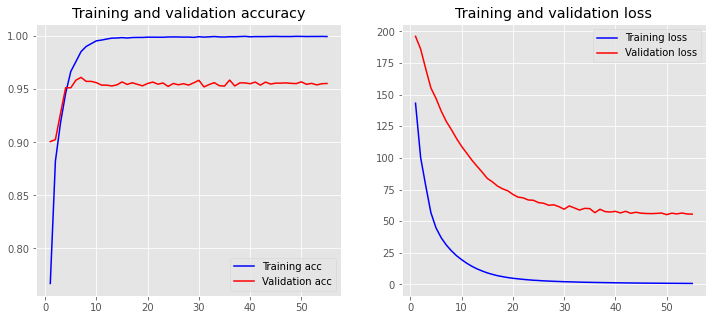

2/2 [==============================] - 3s 58ms/step
F1-score: 55.1%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.6379310344827587,0.74,0.6851851851851852,50.0
DOC_NAME,0.550561797752809,0.5975609756097561,0.5730994152046784,82.0
PARTY,0.5,0.45161290322580644,0.47457627118644063,124.0
micro avg,0.5482625482625483,0.5546875,0.5514563106796116,256.0
macro avg,0.5628309440785225,0.5963912929451874,0.5776202905254348,256.0
weighted avg,0.5431352310151104,0.5546875,0.5472690192701622,256.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Converted 2849 words (4576 misses)
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 226, 100)          742600    
                                                                 
 bidirectional_28 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_28 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_28 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 904,856
Trainable params: 904,856
Non-trainable params

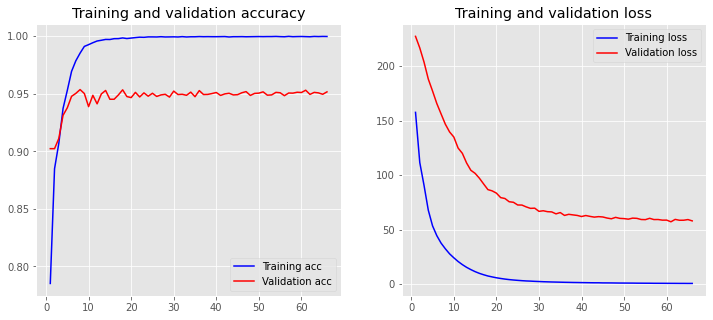

2/2 [==============================] - 3s 58ms/step
F1-score: 52.9%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.5833333333333334,0.7,0.6363636363636365,50.0
DOC_NAME,0.5978260869565217,0.6707317073170732,0.632183908045977,82.0
PARTY,0.408,0.4112903225806452,0.40963855421686746,124.0
micro avg,0.5090252707581228,0.55078125,0.5290806754221388,256.0
macro avg,0.529719806763285,0.5940073432992394,0.559395366208827,256.0
weighted avg,0.5030484601449275,0.55078125,0.525204855472045,256.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Converted 2834 words (4567 misses)
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 226, 100)          740200    
                                                                 
 bidirectional_29 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_29 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_29 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 902,456
Trainable params: 902,456
Non-trainable params

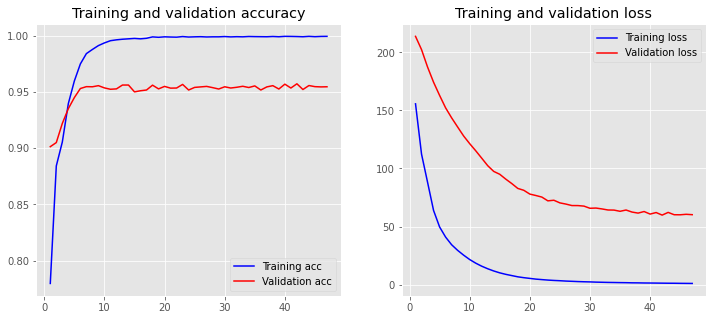

2/2 [==============================] - 3s 57ms/step
F1-score: 56.1%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.6166666666666667,0.74,0.6727272727272727,50.0
DOC_NAME,0.5955056179775281,0.6463414634146342,0.6198830409356725,82.0
PARTY,0.4789915966386555,0.4596774193548387,0.4691358024691358,124.0
micro avg,0.5485074626865671,0.57421875,0.5610687022900763,256.0
macro avg,0.56372129376095,0.6153396275898243,0.5872487053773603,256.0
weighted avg,0.5432021562136091,0.57421875,0.5571859863252406,256.0



In [16]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Converted 2863 words (4620 misses)
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 226, 100)          748400    
                                                                 
 bidirectional_30 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_30 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_30 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 910,656
Trainable params: 910,656
Non-trainable para

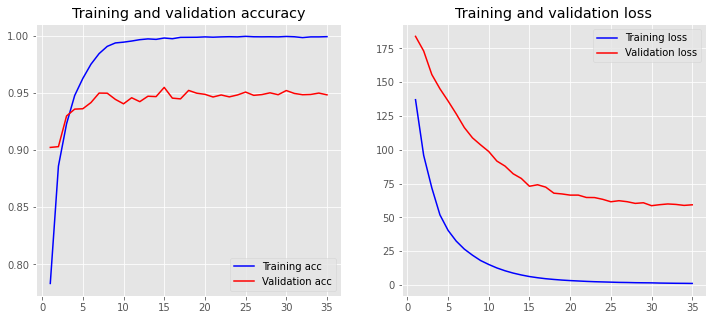

2/2 [==============================] - 3s 62ms/step
F1-score: 54.6%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.6,0.66,0.6285714285714286,50.0
DOC_NAME,0.632183908045977,0.6707317073170732,0.6508875739644969,82.0
PARTY,0.45217391304347826,0.41935483870967744,0.4351464435146443,124.0
micro avg,0.5447470817120622,0.546875,0.5458089668615985,256.0
macro avg,0.5614526070298185,0.5833621820089169,0.5715351486835233,256.0
weighted avg,0.5387056471764118,0.546875,0.5420293417557659,256.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Converted 2836 words (4580 misses)
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 226, 100)          741700    
                                                                 
 bidirectional_31 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_31 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_31 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 903,956
Trainable params: 903,956
Non-trainable para

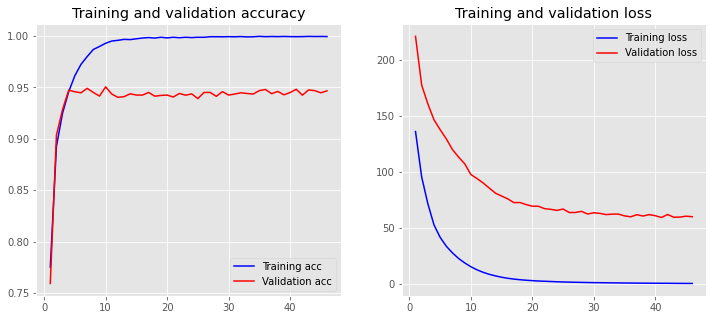

2/2 [==============================] - 3s 59ms/step
F1-score: 52.8%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.75,0.72,0.7346938775510204,50.0
DOC_NAME,0.5824175824175825,0.6463414634146342,0.6127167630057804,82.0
PARTY,0.39823008849557523,0.3629032258064516,0.379746835443038,124.0
micro avg,0.5317460317460317,0.5234375,0.5275590551181103,256.0
macro avg,0.5768825569710526,0.5764148964070285,0.5757191586666129,256.0
weighted avg,0.5259327059831761,0.5234375,0.5236956095271943,256.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Converted 2852 words (4583 misses)
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 226, 100)          743600    
                                                                 
 bidirectional_32 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_32 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_32 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 905,856
Trainable params: 905,856
Non-trainable para

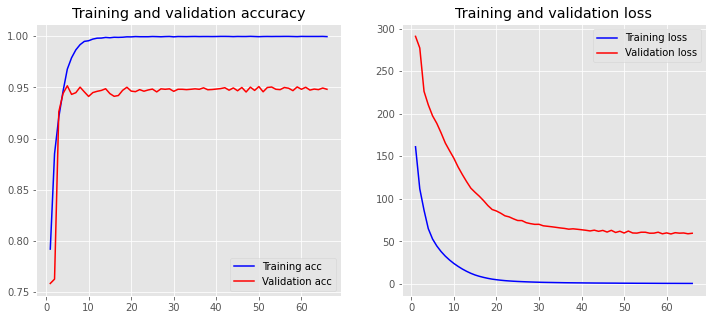

2/2 [==============================] - 3s 57ms/step
F1-score: 52.9%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.5932203389830508,0.7,0.6422018348623852,50.0
DOC_NAME,0.6145833333333334,0.7195121951219512,0.6629213483146068,82.0
PARTY,0.4077669902912621,0.3387096774193548,0.3700440528634361,124.0
micro avg,0.5271317829457365,0.53125,0.529182879377432,256.0
macro avg,0.5385235542025487,0.5860739575137687,0.5583890786801428,256.0
weighted avg,0.5102342073382905,0.53125,0.517012128359309,256.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Converted 2846 words (4584 misses)
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 226, 100)          743100    
                                                                 
 bidirectional_33 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_33 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_33 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 905,356
Trainable params: 905,356
Non-trainable para

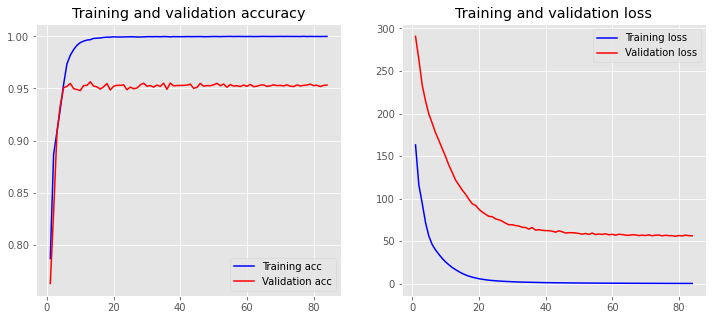

2/2 [==============================] - 3s 57ms/step
F1-score: 50.7%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.5535714285714286,0.62,0.5849056603773586,50.0
DOC_NAME,0.6067415730337079,0.6585365853658537,0.631578947368421,82.0
PARTY,0.3673469387755102,0.43548387096774194,0.3985239852398524,124.0
micro avg,0.476027397260274,0.54296875,0.5072992700729927,256.0
macro avg,0.5092199801268822,0.5713401521111986,0.5383361976618773,256.0
weighted avg,0.48040000322460447,0.54296875,0.5095770737219536,256.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Converted 2844 words (4588 misses)
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, 226, 100)          743300    
                                                                 
 bidirectional_34 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_34 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_34 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 905,556
Trainable params: 905,556
Non-trainable para

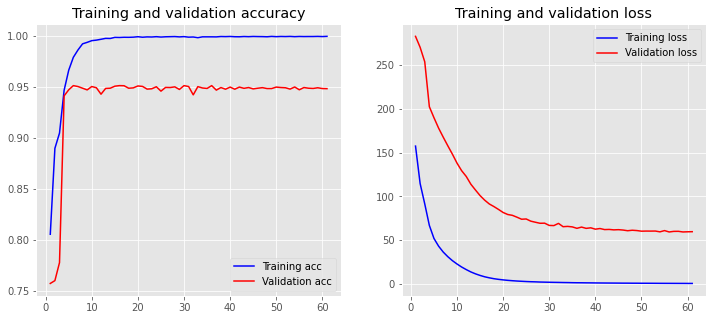

2/2 [==============================] - 3s 59ms/step
F1-score: 52.4%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.6101694915254238,0.72,0.6605504587155964,50.0
DOC_NAME,0.5483870967741935,0.6219512195121951,0.5828571428571429,82.0
PARTY,0.44144144144144143,0.3951612903225806,0.4170212765957446,124.0
micro avg,0.5171102661596958,0.53125,0.5240847784200385,256.0
macro avg,0.5333326765803529,0.5790375032782585,0.553476292722828,256.0
weighted avg,0.5086521689472414,0.53125,0.5177048708903823,256.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Converted 2845 words (4617 misses)
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 226, 100)          746300    
                                                                 
 bidirectional_35 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_35 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_35 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 908,556
Trainable params: 908,556
Non-trainable para

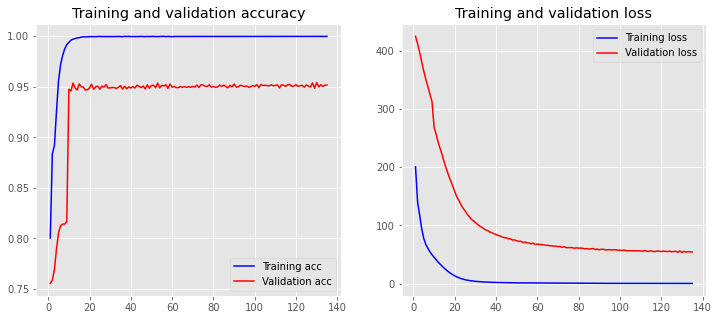

2/2 [==============================] - 3s 62ms/step
F1-score: 55.7%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.6166666666666667,0.74,0.6727272727272727,50.0
DOC_NAME,0.6046511627906976,0.6341463414634146,0.6190476190476191,82.0
PARTY,0.49074074074074076,0.4274193548387097,0.45689655172413796,124.0
micro avg,0.5590551181102362,0.5546875,0.5568627450980392,256.0
macro avg,0.570686190066035,0.6005218987673747,0.5828904811663432,256.0
weighted avg,0.5518225802110249,0.5546875,0.5509900031721152,256.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Converted 2850 words (4588 misses)
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 226, 100)          743900    
                                                                 
 bidirectional_36 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_36 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_36 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 906,156
Trainable params: 906,156
Non-trainable para

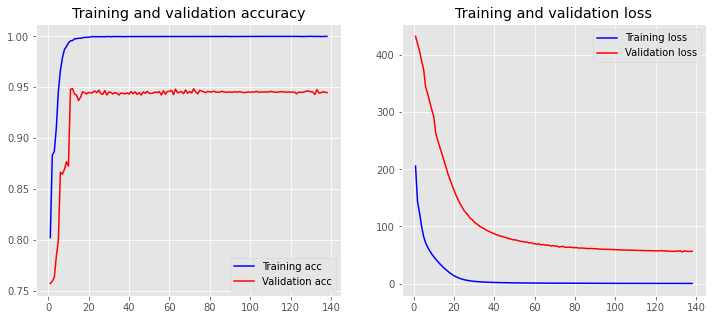

2/2 [==============================] - 3s 58ms/step
F1-score: 48.6%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.5409836065573771,0.66,0.5945945945945946,50.0
DOC_NAME,0.627906976744186,0.6585365853658537,0.6428571428571429,82.0
PARTY,0.33620689655172414,0.31451612903225806,0.32499999999999996,124.0
micro avg,0.4790874524714829,0.4921875,0.48554913294797686,256.0
macro avg,0.5016991599510958,0.5443509047993705,0.5208172458172459,256.0
weighted avg,0.4696375296613512,0.4921875,0.47946881032818534,256.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Converted 2839 words (4591 misses)
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, 226, 100)          743100    
                                                                 
 bidirectional_37 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_37 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_37 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 905,356
Trainable params: 905,356
Non-trainable para

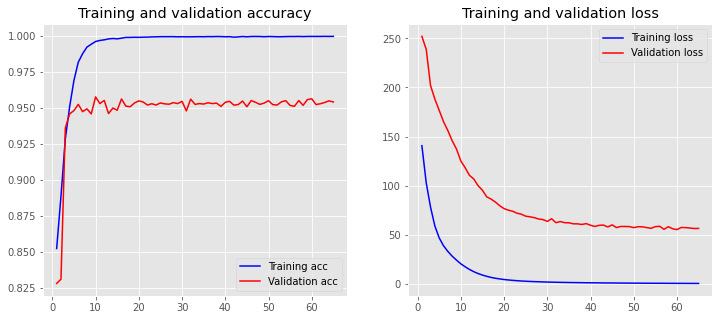

2/2 [==============================] - 3s 61ms/step
F1-score: 54.1%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.7058823529411765,0.72,0.712871287128713,50.0
DOC_NAME,0.5777777777777777,0.6341463414634146,0.6046511627906976,82.0
PARTY,0.421875,0.43548387096774194,0.42857142857142855,124.0
micro avg,0.5278810408921933,0.5546875,0.5409523809523809,256.0
macro avg,0.5685117102396514,0.5965434041437189,0.5820312928302797,256.0
weighted avg,0.527282794628268,0.5546875,0.5404992845630078,256.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Converted 2840 words (4581 misses)
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, 226, 100)          742200    
                                                                 
 bidirectional_38 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_38 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_38 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 904,456
Trainable params: 904,456
Non-trainable para

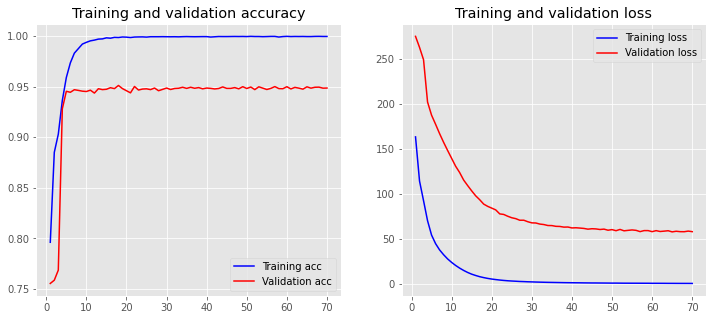

2/2 [==============================] - 3s 61ms/step
F1-score: 50.0%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.6481481481481481,0.7,0.673076923076923,50.0
DOC_NAME,0.6436781609195402,0.6829268292682927,0.6627218934911242,82.0
PARTY,0.31297709923664124,0.33064516129032256,0.32156862745098036,124.0
micro avg,0.4852941176470588,0.515625,0.5,256.0
macro avg,0.5349344694347765,0.5711906635195384,0.5524558146730092,256.0
weighted avg,0.4843678785474735,0.515625,0.4994982469689059,256.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Converted 2856 words (4587 misses)
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, 226, 100)          744400    
                                                                 
 bidirectional_39 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_39 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_39 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 906,656
Trainable params: 906,656
Non-trainable para

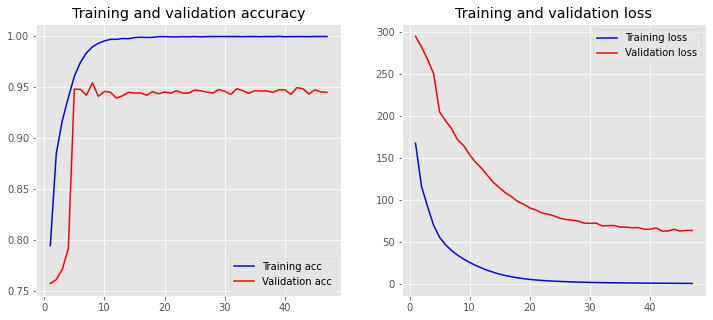

2/2 [==============================] - 3s 57ms/step
F1-score: 50.4%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.5769230769230769,0.6,0.5882352941176471,50.0
DOC_NAME,0.5795454545454546,0.6219512195121951,0.6,82.0
PARTY,0.3984375,0.4112903225806452,0.4047619047619047,124.0
micro avg,0.4925373134328358,0.515625,0.5038167938931298,256.0
macro avg,0.5183020104895105,0.5444138473642801,0.5309990662931839,256.0
weighted avg,0.4913091059331294,0.515625,0.5031337535014005,256.0



In [17]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Converted 2901 words (4676 misses)
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 226, 100)          757800    
                                                                 
 bidirectional_40 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_40 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_40 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 920,056
Trainable params: 920,056
Non-trainable para

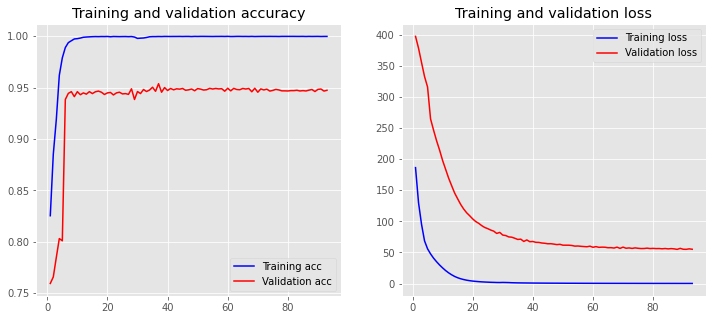

2/2 [==============================] - 3s 60ms/step
F1-score: 50.8%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.5370370370370371,0.58,0.5576923076923077,50.0
DOC_NAME,0.6551724137931034,0.6951219512195121,0.6745562130177514,82.0
PARTY,0.3925233644859813,0.3387096774193548,0.36363636363636365,124.0
micro avg,0.5161290322580645,0.5,0.5079365079365079,256.0
macro avg,0.5282442717720406,0.5379438762129556,0.5319616281154742,256.0
weighted avg,0.5048784647622969,0.49999999999999994,0.501129429464766,256.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Converted 2904 words (4672 misses)
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    (None, 226, 100)          757700    
                                                                 
 bidirectional_41 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_41 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_41 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 919,956
Trainable params: 919,956
Non-trainable para

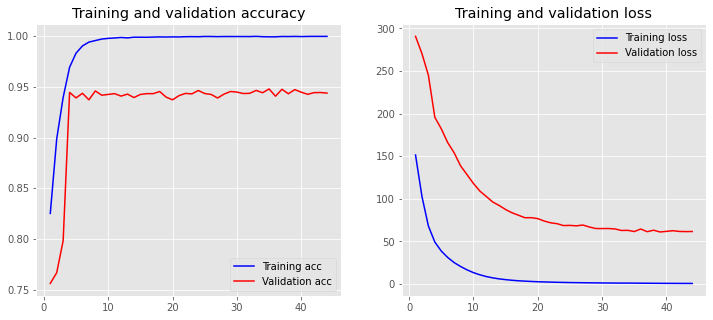

2/2 [==============================] - 3s 56ms/step
F1-score: 50.3%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.5925925925925926,0.64,0.6153846153846153,50.0
DOC_NAME,0.5632183908045977,0.5975609756097561,0.5798816568047337,82.0
PARTY,0.4479166666666667,0.3467741935483871,0.39090909090909093,124.0
micro avg,0.5232067510548524,0.484375,0.5030425963488844,256.0
macro avg,0.5345758833546189,0.5281117230527145,0.5287251210328133,256.0
weighted avg,0.5131062669620051,0.484375,0.4952822417966648,256.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Converted 2904 words (4681 misses)
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_42 (Embedding)    (None, 226, 100)          758600    
                                                                 
 bidirectional_42 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_42 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_42 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 920,856
Trainable params: 920,856
Non-trainable para

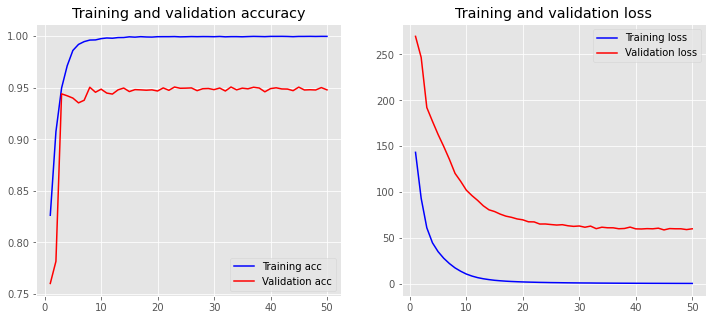

2/2 [==============================] - 3s 62ms/step
F1-score: 52.9%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.6481481481481481,0.7,0.673076923076923,50.0
DOC_NAME,0.6067415730337079,0.6585365853658537,0.631578947368421,82.0
PARTY,0.3983739837398374,0.3951612903225806,0.3967611336032389,124.0
micro avg,0.518796992481203,0.5390625,0.528735632183908,256.0
macro avg,0.5510879016405644,0.5845659585628113,0.5671390013495277,256.0
weighted avg,0.5139007436715285,0.5390625,0.5259441422064778,256.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Converted 2901 words (4691 misses)
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_43 (Embedding)    (None, 226, 100)          759300    
                                                                 
 bidirectional_43 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_43 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_43 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 921,556
Trainable params: 921,556
Non-trainable para

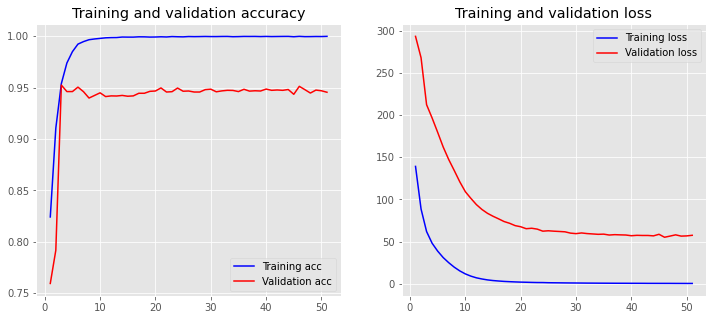

2/2 [==============================] - 3s 59ms/step
F1-score: 52.8%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.6296296296296297,0.68,0.6538461538461539,50.0
DOC_NAME,0.6091954022988506,0.6463414634146342,0.6272189349112427,82.0
PARTY,0.4368932038834951,0.3629032258064516,0.3964757709251101,124.0
micro avg,0.5409836065573771,0.515625,0.528,256.0
macro avg,0.5585727452706585,0.5630815630736953,0.5591802865608355,256.0
weighted avg,0.5297275849669556,0.515625,0.5206533435536845,256.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Converted 2891 words (4642 misses)
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_44 (Embedding)    (None, 226, 100)          753400    
                                                                 
 bidirectional_44 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_44 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_44 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 915,656
Trainable params: 915,656
Non-trainable para

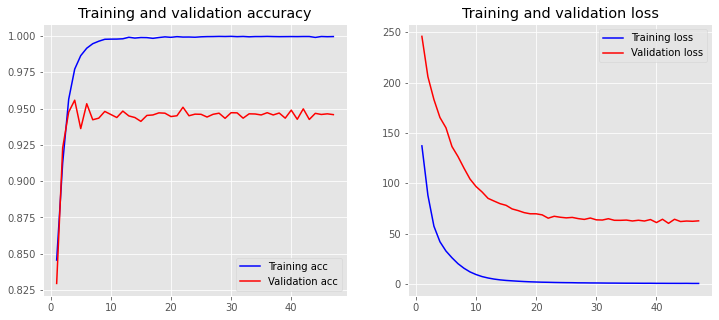

2/2 [==============================] - 3s 63ms/step
F1-score: 53.0%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.7450980392156863,0.76,0.7524752475247525,50.0
DOC_NAME,0.5824175824175825,0.6463414634146342,0.6127167630057804,82.0
PARTY,0.41,0.33064516129032256,0.3660714285714286,124.0
micro avg,0.5454545454545454,0.515625,0.5301204819277109,256.0
macro avg,0.5791718738777563,0.5789955415683189,0.5770878130339872,256.0
weighted avg,0.5306763426524456,0.515625,0.5205445081467529,256.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Converted 2900 words (4672 misses)
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_45 (Embedding)    (None, 226, 100)          757300    
                                                                 
 bidirectional_45 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_45 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_45 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 919,556
Trainable params: 919,556
Non-trainable para

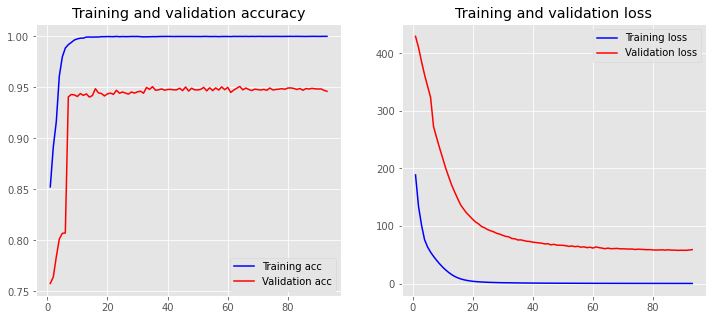

2/2 [==============================] - 3s 62ms/step
F1-score: 49.4%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.5535714285714286,0.62,0.5849056603773586,50.0
DOC_NAME,0.6419753086419753,0.6341463414634146,0.638036809815951,82.0
PARTY,0.38095238095238093,0.3225806451612903,0.34934497816593885,124.0
micro avg,0.5082644628099173,0.48046875,0.4939759036144578,256.0
macro avg,0.5254997060552616,0.5255756622082349,0.5240958161197494,256.0
weighted avg,0.49827594521604934,0.48046875,0.4878245262357513,256.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Converted 2891 words (4677 misses)
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_46 (Embedding)    (None, 226, 100)          756900    
                                                                 
 bidirectional_46 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_46 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_46 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 919,156
Trainable params: 919,156
Non-trainable para

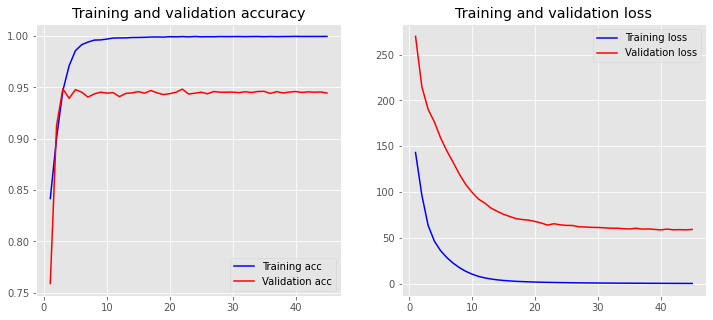

2/2 [==============================] - 3s 57ms/step
F1-score: 51.1%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.6607142857142857,0.74,0.6981132075471698,50.0
DOC_NAME,0.6136363636363636,0.6585365853658537,0.6352941176470588,82.0
PARTY,0.3763440860215054,0.28225806451612906,0.3225806451612903,124.0
micro avg,0.5316455696202531,0.4921875,0.511156186612576,256.0
macro avg,0.5502315784573849,0.5602648832939942,0.5519959901185063,256.0
weighted avg,0.5078928233225108,0.4921875,0.4960928829078801,256.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Converted 2886 words (4694 misses)
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_47 (Embedding)    (None, 226, 100)          758100    
                                                                 
 bidirectional_47 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_47 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_47 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 920,356
Trainable params: 920,356
Non-trainable para

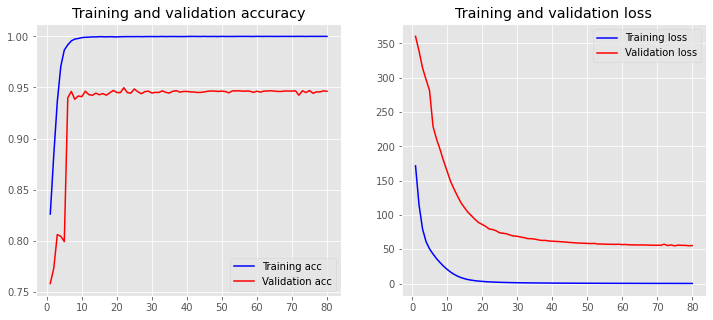

2/2 [==============================] - 3s 59ms/step
F1-score: 52.3%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.6,0.72,0.6545454545454547,50.0
DOC_NAME,0.5760869565217391,0.6463414634146342,0.6091954022988506,82.0
PARTY,0.4606741573033708,0.33064516129032256,0.38497652582159625,124.0
micro avg,0.5394190871369294,0.5078125,0.5231388329979879,256.0
macro avg,0.5455870379417033,0.5656622082349855,0.5495724608886338,256.0
weighted avg,0.5248543982046898,0.5078125,0.5094468160845953,256.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Converted 2887 words (4697 misses)
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_48 (Embedding)    (None, 226, 100)          758500    
                                                                 
 bidirectional_48 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_48 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_48 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 920,756
Trainable params: 920,756
Non-trainable para

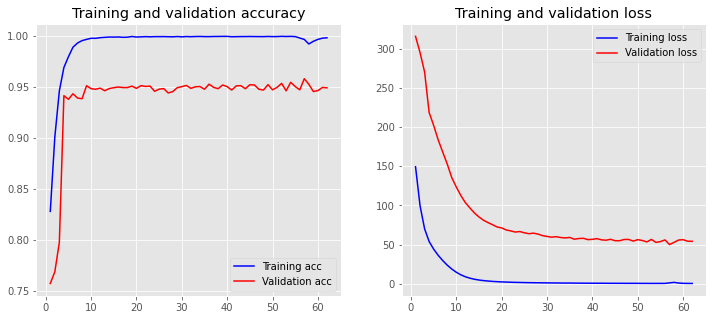

2/2 [==============================] - 3s 59ms/step
F1-score: 58.0%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.5081967213114754,0.62,0.5585585585585586,50.0
DOC_NAME,0.6043956043956044,0.6707317073170732,0.6358381502890174,82.0
PARTY,0.5384615384615384,0.5645161290322581,0.5511811023622047,124.0
micro avg,0.5531914893617021,0.609375,0.5799256505576208,256.0
macro avg,0.550351288056206,0.6184159454497772,0.5818592704032602,256.0
weighted avg,0.5536699468564221,0.609375,0.5797387224396123,256.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Converted 2900 words (4645 misses)
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_49 (Embedding)    (None, 226, 100)          754600    
                                                                 
 bidirectional_49 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_49 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_49 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 916,856
Trainable params: 916,856
Non-trainable para

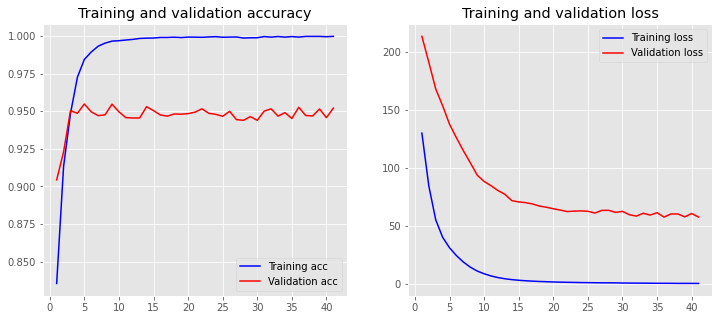

2/2 [==============================] - 3s 57ms/step
F1-score: 52.5%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.6538461538461539,0.68,0.6666666666666666,50.0
DOC_NAME,0.5257731958762887,0.6219512195121951,0.5698324022346369,82.0
PARTY,0.4666666666666667,0.3951612903225806,0.4279475982532751,124.0
micro avg,0.5275590551181102,0.5234375,0.5254901960784314,256.0
macro avg,0.5487620054630363,0.5657041699449253,0.5548155557181929,256.0
weighted avg,0.5221577203938673,0.5234375,0.5200198925780455,256.0



In [18]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 3030 words (4882 misses)
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_50 (Embedding)    (None, 226, 100)          791300    
                                                                 
 bidirectional_50 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_50 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_50 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 953,556
Trainable params: 953,556
Non-trainable para

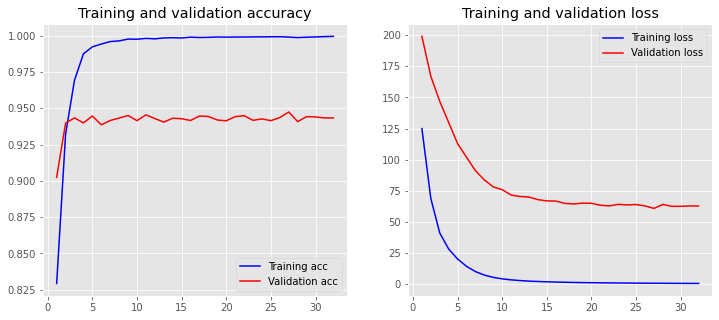

2/2 [==============================] - 3s 58ms/step
F1-score: 50.4%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.5849056603773585,0.62,0.6019417475728155,50.0
DOC_NAME,0.6470588235294118,0.6707317073170732,0.658682634730539,82.0
PARTY,0.3877551020408163,0.3064516129032258,0.3423423423423424,124.0
micro avg,0.5254237288135594,0.484375,0.5040650406504066,256.0
macro avg,0.5399065286491955,0.532394440073433,0.5343222415485657,256.0
weighted avg,0.509319293755238,0.484375,0.49437310108201343,256.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 3024 words (4865 misses)
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_51 (Embedding)    (None, 226, 100)          789000    
                                                                 
 bidirectional_51 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_51 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_51 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 951,256
Trainable params: 951,256
Non-trainable para

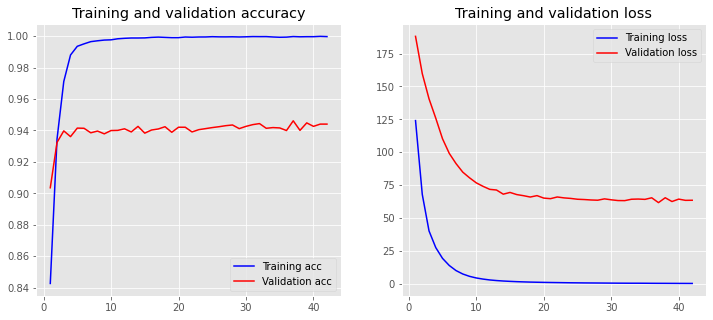

2/2 [==============================] - 3s 59ms/step
F1-score: 49.7%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.6041666666666666,0.58,0.5918367346938774,50.0
DOC_NAME,0.5806451612903226,0.6585365853658537,0.6171428571428572,82.0
PARTY,0.4019607843137255,0.33064516129032256,0.3628318584070796,124.0
micro avg,0.5102880658436214,0.484375,0.4969939879759519,256.0
macro avg,0.5289242040902383,0.5230605822187254,0.5239371500812714,256.0
weighted avg,0.4986889602111006,0.484375,0.48901836508939855,256.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 3007 words (4868 misses)
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_52 (Embedding)    (None, 226, 100)          787600    
                                                                 
 bidirectional_52 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_52 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_52 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 949,856
Trainable params: 949,856
Non-trainable para

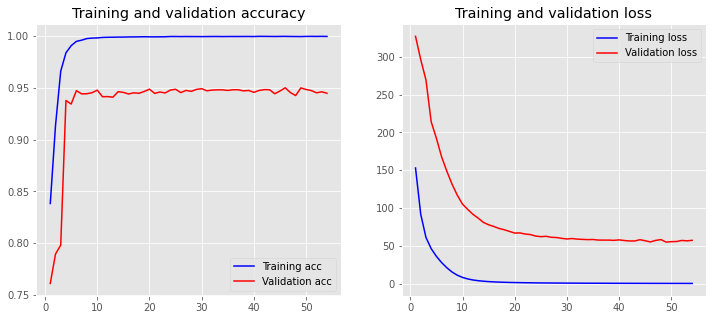

2/2 [==============================] - 3s 58ms/step
F1-score: 50.6%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.5918367346938775,0.58,0.5858585858585857,50.0
DOC_NAME,0.6395348837209303,0.6707317073170732,0.6547619047619049,82.0
PARTY,0.39805825242718446,0.33064516129032256,0.36123348017621143,124.0
micro avg,0.5252100840336135,0.48828125,0.5060728744939272,256.0
macro avg,0.5431432902806641,0.5271256228691319,0.5339513235989007,256.0
weighted avg,0.5132535957061759,0.48828125,0.49912639462990505,256.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 2992 words (4842 misses)
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_53 (Embedding)    (None, 226, 100)          783500    
                                                                 
 bidirectional_53 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_53 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_53 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 945,756
Trainable params: 945,756
Non-trainable para

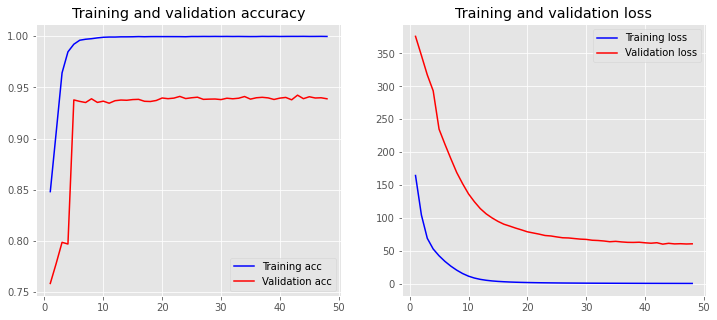

2/2 [==============================] - 3s 65ms/step
F1-score: 47.4%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.5,0.54,0.5192307692307693,50.0
DOC_NAME,0.6585365853658537,0.6585365853658537,0.6585365853658537,82.0
PARTY,0.4117647058823529,0.22580645161290322,0.29166666666666663,124.0
micro avg,0.5343137254901961,0.42578125,0.4739130434782609,256.0
macro avg,0.5234337637494022,0.47478101232625236,0.4898113404210965,256.0
weighted avg,0.5080422794117647,0.42578125,0.4536258012820513,256.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 3008 words (4920 misses)
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_54 (Embedding)    (None, 226, 100)          792900    
                                                                 
 bidirectional_54 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_54 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_54 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 955,156
Trainable params: 955,156
Non-trainable para

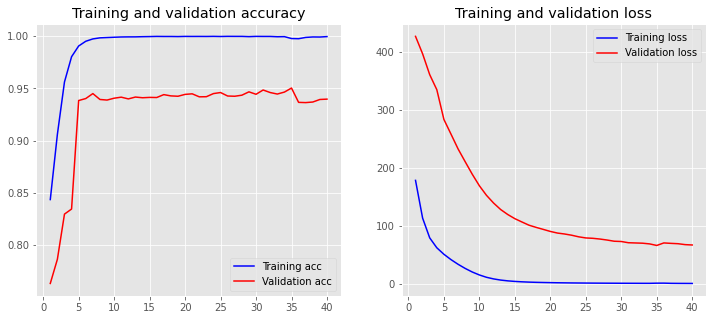

2/2 [==============================] - 3s 66ms/step
F1-score: 45.1%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.5178571428571429,0.58,0.5471698113207547,50.0
DOC_NAME,0.5652173913043478,0.6341463414634146,0.5977011494252873,82.0
PARTY,0.3007518796992481,0.3225806451612903,0.311284046692607,124.0
micro avg,0.4306049822064057,0.47265625,0.45065176908752325,256.0
macro avg,0.46127547128691293,0.5122423288749016,0.48538500247954963,256.0
weighted avg,0.42786686059578294,0.47265625,0.44909846331560377,256.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 3001 words (4874 misses)
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_55 (Embedding)    (None, 226, 100)          787600    
                                                                 
 bidirectional_55 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_55 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_55 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 949,856
Trainable params: 949,856
Non-trainable para

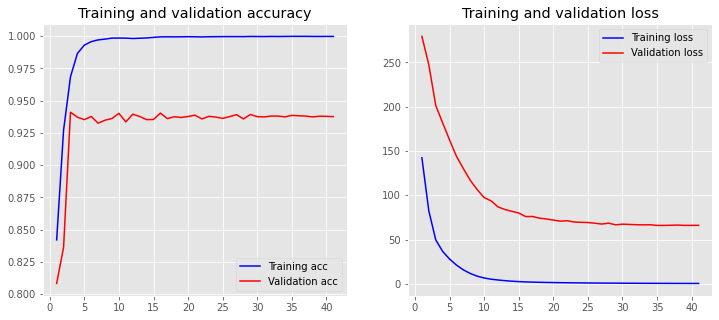

2/2 [==============================] - 3s 59ms/step
F1-score: 46.3%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.5714285714285714,0.56,0.5656565656565656,50.0
DOC_NAME,0.6547619047619048,0.6707317073170732,0.6626506024096386,82.0
PARTY,0.32051282051282054,0.20161290322580644,0.24752475247524752,124.0
micro avg,0.5118483412322274,0.421875,0.4625267665952891,256.0
macro avg,0.5155677655677656,0.4774482035142933,0.4919439735138172,256.0
weighted avg,0.47658396291208793,0.421875,0.4426298710443334,256.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 3019 words (4896 misses)
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_56 (Embedding)    (None, 226, 100)          791600    
                                                                 
 bidirectional_56 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_56 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_56 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 953,856
Trainable params: 953,856
Non-trainable para

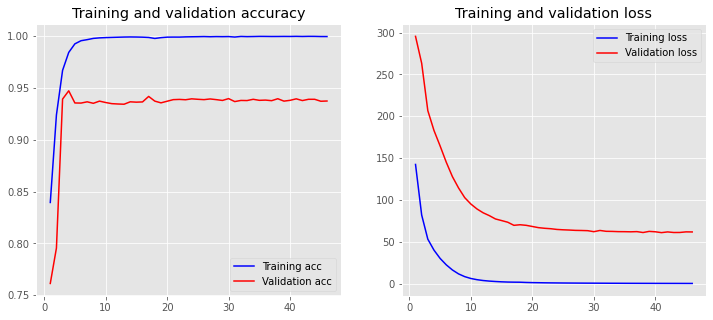

2/2 [==============================] - 3s 59ms/step
F1-score: 47.6%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.6511627906976745,0.56,0.6021505376344087,50.0
DOC_NAME,0.6265060240963856,0.6341463414634146,0.6303030303030304,82.0
PARTY,0.3815789473684211,0.23387096774193547,0.29000000000000004,124.0
micro avg,0.5396039603960396,0.42578125,0.4759825327510917,256.0
macro avg,0.5530825873874937,0.47600576973511677,0.507484522645813,256.0
weighted avg,0.512685246033092,0.42578125,0.45997021627565987,256.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 2990 words (4840 misses)
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_57 (Embedding)    (None, 226, 100)          783100    
                                                                 
 bidirectional_57 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_57 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_57 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 945,356
Trainable params: 945,356
Non-trainable para

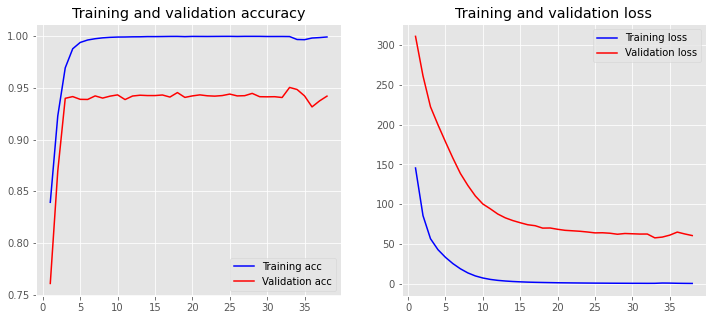

2/2 [==============================] - 3s 58ms/step
F1-score: 49.0%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.5535714285714286,0.62,0.5849056603773586,50.0
DOC_NAME,0.6547619047619048,0.6707317073170732,0.6626506024096386,82.0
PARTY,0.3389830508474576,0.3225806451612903,0.3305785123966942,124.0
micro avg,0.4883720930232558,0.4921875,0.490272373540856,256.0
macro avg,0.5157721280602637,0.5377707841594545,0.5260449250612305,256.0
weighted avg,0.48204275751614206,0.4921875,0.48661862481893897,256.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 3010 words (4895 misses)
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_58 (Embedding)    (None, 226, 100)          790600    
                                                                 
 bidirectional_58 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_58 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_58 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 952,856
Trainable params: 952,856
Non-trainable para

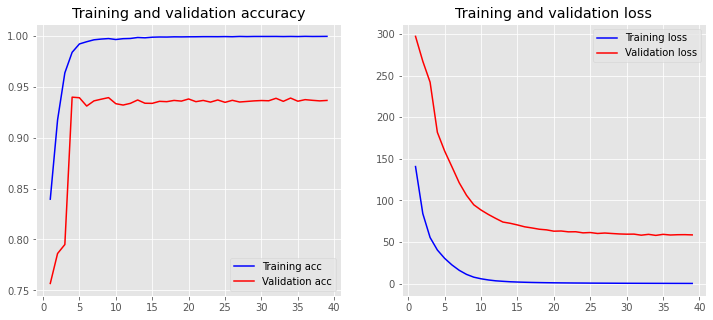

2/2 [==============================] - 3s 61ms/step
F1-score: 48.1%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.7209302325581395,0.62,0.6666666666666666,50.0
DOC_NAME,0.6493506493506493,0.6097560975609756,0.6289308176100628,82.0
PARTY,0.3698630136986301,0.21774193548387097,0.2741116751269036,124.0
micro avg,0.5595854922279793,0.421875,0.48106904231625836,256.0
macro avg,0.5800479652024729,0.4824993443482822,0.5232363864678776,256.0
weighted avg,0.5279542131769155,0.421875,0.46443557848865047,256.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 3018 words (4873 misses)
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_59 (Embedding)    (None, 226, 100)          789200    
                                                                 
 bidirectional_59 (Bidirecti  (None, 226, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_59 (TimeDi  (None, 226, 7)           1407      
 stributed)                                                      
                                                                 
 crf_59 (CRF)                (None, 226, 7)            49        
                                                                 
Total params: 951,456
Trainable params: 951,456
Non-trainable para

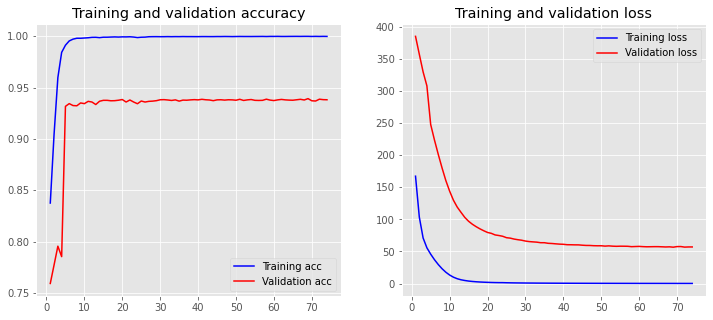

2/2 [==============================] - 3s 61ms/step
F1-score: 51.7%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.6808510638297872,0.64,0.6597938144329897,50.0
DOC_NAME,0.7088607594936709,0.6829268292682927,0.6956521739130436,82.0
PARTY,0.417910447761194,0.22580645161290322,0.2931937172774869,124.0
micro avg,0.6010362694300518,0.453125,0.5167037861915368,256.0
macro avg,0.6025407570282173,0.5162444269603986,0.5495465685411735,256.0
weighted avg,0.5624610585639,0.453125,0.49370777314424774,256.0



In [19]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)